# Install PySpark

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 38 kB/s 
     |████████████████████████████████| 199 kB 61.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=f09e972107ac4ae108229eaa85634b9e303d74071b5798c067edf1f27f6d16f5
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Change the directory

In [3]:
import os
os.chdir('/content/drive/MyDrive/MIS584/')

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MIS_584_Yelp_Project").getOrCreate()

# you can get a spark context from a spark session
sc = spark.sparkContext

In [5]:
import pandas as pd
import seaborn as sns
%pylab inline
# pd.set_option('display.max_columns',None)
pd.options.display.max_seq_items = 2000
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import requests, re
import pandas as pd
import seaborn as sns
import nltk
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import json
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score,\
    precision_score, f1_score, roc_auc_score

Populating the interactive namespace from numpy and matplotlib


In [6]:
data_file = open("yelp_academic_dataset_business.json")
data = []
for line in data_file:
  data.append(json.loads(line))
business_df = pd.DataFrame(data)
data_file.close()

In [7]:
print("Number of observations in yelp biz dataset: ",business_df.shape[0])

#business_df.count()) #150346
# business_df.show(2)
print(" ")
print("Attributes of yelp biz dataset: ")
print(business_df.columns)
print(" ")
print("First 10 observations in yelp biz dataset: ")
print(business_df.head(10))

Number of observations in yelp biz dataset:  150346
 
Attributes of yelp biz dataset: 
Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours'], dtype='object')
 
First 10 observations in yelp biz dataset: 
              business_id                      name                                     address            city state postal_code   latitude   longitude  stars  review_count  is_open                                         attributes                                         categories                                              hours
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ                      1616 Chapala St, Ste 2   Santa Barbara    CA       93101  34.426679 -119.711197    5.0             7        0                      {'ByAppointmentOnly': 'True'}  Doctors, Traditional Chinese Medicine, Naturop...                                               None
1  mpf3

In [8]:
business_df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,3388 Gateway Blvd,Edmonton,AB,T6J 5H2,53.468419,-113.492054,3.0,13,1,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas","{'Monday': '10:0-19:30', 'Tuesday': '10:0-19:3..."
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,2813 Bransford Ave,Nashville,TN,37204,36.115118,-86.766925,4.0,5,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3..."
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"6020 E 82nd St, Ste 46",Indianapolis,IN,46250,39.908707,-86.065088,3.5,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",None
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,2472 Troy Rd,Edwardsville,IL,62025,38.782351,-89.950558,4.0,24,1,"{'BusinessParking': '{'garage': False, 'street...","Fitness/Exercise Equipment, Eyewear & Optician...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."


In [9]:
data_file = open("yelp_academic_dataset_review.json")
data = []
for line in data_file:
  if json.loads(line)['date'] >= "2021-01-01 00:00:00" and json.loads(line)['date'] < "2022-01-01 00:00:00":
    data.append(json.loads(line))
review_df = pd.DataFrame(data)
data_file.close()

In [10]:
#review_df.count() 
# review_df.show(2)
print("Number of observations in yelp review dataset: ",review_df.shape[0])

print(" ")
print("Attributes of yelp review dataset: ")
print(review_df.columns)
print(" ")
print("First 10 observations in review biz dataset: ")
print(review_df.head(10))



Number of observations in yelp review dataset:  618189
 
Attributes of yelp review dataset: 
Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date'], dtype='object')
 
First 10 observations in review biz dataset: 
                review_id                 user_id             business_id  stars  useful  funny  cool                                               text                 date
0  iBUJvIOkToh2ZECVNq5PDg  iAD32p6h32eKDVxsPHSRHA  YB26JvvGS2LgkxEKOObSAw    5.0       0      0     0  I've been eating at this restaurant for over 5...  2021-01-08 01:49:36
1  HgEofz6qEQqKYPT7YLA34w  rYvWv-Ny16b1lMcw1IP7JQ  jfIwOEXcVRyhZjM4ISOh4g    1.0       0      0     0  How does a delivery person from here get lost ...  2021-01-02 00:19:00
2  milJ7UH4Od9pBe2gWac9tA  v7i4M7NIx3bMNMChaXjU7Q  raKflkp3CANr8N7qpQ3ZyQ    5.0       0      0     0  I WISH I was still a Sierra resident. They're ...  2021-02-02 18:14:15
3  Kxo5d6EOnOE-vERwQf2a1w  2ntnbUia9Bna62W0fqNcx

In [11]:
## remove quotation marks in name and address column
business_df.name=business_df.name.str.replace('"','')
business_df.address=business_df.address.str.replace('"','')

# from pyspark.sql.functions import *
# business_df = (business_df
#               .withColumn('name', regexp_replace('name', '"', ''))
#               .withColumn('address', regexp_replace('address', '"', ''))
#               )


## filter restaurants of US
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

# usa = business_df.filter(business_df['state'].isin(states))

usa=business_df.loc[business_df['state'].isin(states)]
# business_df.head(2)
# usa.head(2)
# print(business_df.count()) #150346
# print(usa.count()) #144771
usa = usa.dropna()
# print(usa.count()) #113506

print("Number of observations in yelp biz dataset: ",business_df.shape[0])
print(" ")
print("Number of observations in yelp USA biz dataset: ",usa.shape[0])
print(" ")
print("Attributes of yelp biz dataset: ")
print(business_df.columns)
print(" ")
print("First 10 observations in yelp USA biz dataset: ")
print(usa.head(10))


Number of observations in yelp biz dataset:  150346
 
Number of observations in yelp USA biz dataset:  113506
 
Attributes of yelp biz dataset: 
Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours'], dtype='object')
 
First 10 observations in yelp USA biz dataset: 
               business_id                      name                                     address           city state postal_code   latitude   longitude  stars  review_count  is_open                                         attributes                                         categories                                              hours
1   mpf3x-BjTdTEA3yCZrAYPw             The UPS Store             87 Grasso Plaza Shopping Center         Affton    MO       63123  38.551126  -90.335695    3.0            15        1             {'BusinessAcceptsCreditCards': 'True'}  Shipping Centers, Local Services, Notaries, Ma

In [ ]:
usa['state'].nunique()

22

In [ ]:
## select all restaurants in USA
us_restaurants=usa[usa['categories'].str.contains('Restaurants')]
# us_restaurants= usa.filter(col('categories').contains('Restaurants'))
print("Number of observations in yelp USA restaurants biz dataset: ",us_restaurants.shape[0])
#print(us_restaurants.count())

## select out 16 cuisine types of restaurants and rename the category
us_restaurants.is_copy=False

Number of observations in yelp USA restaurants biz dataset:  42691


In [ ]:
# us_restaurants = (us_restaurants
#  .withColumn('category', when(us_restaurants.categories.contains('American'), 'American')
#                         .when(us_restaurants.categories.contains('Mexican'), 'Mexican')
#                         .when(us_restaurants.categories.contains('Italian'), 'Italian')
#                         .when(us_restaurants.categories.contains('Japanese'), 'Japanese')
#                         .when(us_restaurants.categories.contains('Chinese'), 'Chinese')
#                         .when(us_restaurants.categories.contains('Thai'), 'Thai')
#                         .when(us_restaurants.categories.contains('Mediterranean'), 'Mediterranean')
#                         .when(us_restaurants.categories.contains('French'), 'French')
#                         .when(us_restaurants.categories.contains('Vietnamese'), 'Vietnamese')
#                         .when(us_restaurants.categories.contains('Greek'), 'Greek')
#                         .when(us_restaurants.categories.contains('Indian'), 'Indian')
#                         .when(us_restaurants.categories.contains('Korean'), 'Korean')
#                         .when(us_restaurants.categories.contains('Hawaiian'), 'Hawaiian')
#                         .when(us_restaurants.categories.contains('African'), 'African')
#                         .when(us_restaurants.categories.contains('Spanish'), 'Spanish')
#                         .when(us_restaurants.categories.contains('Middle_eastern'), 'Middle_eastern'))
#  )

us_restaurants.loc[us_restaurants.categories.str.contains('American'),'category'] = 'American'
us_restaurants.loc[us_restaurants.categories.str.contains('Mexican'), 'category'] = 'Mexican'
us_restaurants.loc[us_restaurants.categories.str.contains('Italian'), 'category'] = 'Italian'
us_restaurants.loc[us_restaurants.categories.str.contains('Japanese'), 'category'] = 'Japanese'
us_restaurants.loc[us_restaurants.categories.str.contains('Chinese'), 'category'] = 'Chinese'
us_restaurants.loc[us_restaurants.categories.str.contains('Thai'), 'category'] = 'Thai'
us_restaurants.loc[us_restaurants.categories.str.contains('Mediterranean'), 'category'] = 'Mediterranean'
us_restaurants.loc[us_restaurants.categories.str.contains('French'), 'category'] = 'French'
us_restaurants.loc[us_restaurants.categories.str.contains('Vietnamese'), 'category'] = 'Vietnamese'
us_restaurants.loc[us_restaurants.categories.str.contains('Greek'),'category'] = 'Greek'
us_restaurants.loc[us_restaurants.categories.str.contains('Indian'),'category'] = 'Indian'
us_restaurants.loc[us_restaurants.categories.str.contains('Korean'),'category'] = 'Korean'
us_restaurants.loc[us_restaurants.categories.str.contains('Hawaiian'),'category'] = 'Hawaiian'
us_restaurants.loc[us_restaurants.categories.str.contains('African'),'category'] = 'African'
us_restaurants.loc[us_restaurants.categories.str.contains('Spanish'),'category'] = 'Spanish'
us_restaurants.loc[us_restaurants.categories.str.contains('Middle_eastern'),'category'] = 'Middle_eastern'
us_restaurants.category[:20]
# print(us_restaurants.select('category').distinct().show())
print("Number of observations in yelp USA restaurants biz dataset: ",us_restaurants.shape[0])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Number of observations in yelp USA restaurants biz dataset:  42691


In [ ]:
us_restaurants.describe()
#print(us_restaurants.count())


,latitude,longitude,stars,review_count,is_open
count,42691.000000,42691.000000,42691.000000,42691.000000,42691.000000
mean,36.143677,-86.632285,3.543639,101.620880,0.700429
std,4.927352,12.833402,0.825189,205.608301,0.458076
min,27.564457,-120.083748,1.000000,5.000000,0.000000
25%,30.020979,-90.120176,3.000000,18.000000,0.000000
50%,38.702424,-82.787305,3.500000,43.000000,1.000000
75%,39.949028,-75.319819,4.000000,109.000000,1.000000
max,43.773686,-74.664459,5.000000,7568.000000,1.000000


In [ ]:
us_restaurants.describe()

,latitude,longitude,stars,review_count,is_open
count,42691.000000,42691.000000,42691.000000,42691.000000,42691.000000
mean,36.143677,-86.632285,3.543639,101.620880,0.700429
std,4.927352,12.833402,0.825189,205.608301,0.458076
min,27.564457,-120.083748,1.000000,5.000000,0.000000
25%,30.020979,-90.120176,3.000000,18.000000,0.000000
50%,38.702424,-82.787305,3.500000,43.000000,1.000000
75%,39.949028,-75.319819,4.000000,109.000000,1.000000
max,43.773686,-74.664459,5.000000,7568.000000,1.000000


In [ ]:
us_restaurants['state'].nunique()

15

In [ ]:
## drop null values in category, delete original column categories and reset the index
us_restaurants=us_restaurants.dropna(subset=['category'])

# del us_restaurants['categories', 'attributes', 'hours']
us_restaurants = us_restaurants.drop(['categories', 'attributes', 'hours'], axis=1)
us_restaurants=us_restaurants.reset_index(drop=True)
print("Number of observations in yelp USA restaurants biz dataset: ",us_restaurants.shape[0])
print(" ")
print(" ")
print("First 10 Observations in yelp us restaurants dataset:")
print(" ")
print(us_restaurants.head(10))

#print(us_restaurants.count())

Number of observations in yelp USA restaurants biz dataset:  24909
 
 
First 10 Observations in yelp us restaurants dataset:
 
              business_id                                 name             address          city state postal_code   latitude   longitude  stars  review_count  is_open    category
0  eEOYSgkmpB90uNA7lDOMRA                Vietnamese Food Truck                         Tampa Bay    FL       33602  27.955269  -82.456320    4.0            10        1  Vietnamese
1  il_Ro8jwPlHresjw9EGmBg                              Denny's        8901 US 31 S  Indianapolis    IN       46227  39.637133  -86.127217    2.5            28        1    American
2  0bPLkL0QhhPO5kt1_EXmNQ                 Zio's Italian Market       2575 E Bay Dr         Largo    FL       33771  27.916116  -82.760461    4.5           100        0     Italian
3  MUTTqe8uqyMdBl186RmNeA                             Tuna Bar         205 Race St  Philadelphia    PA       19106  39.953949  -75.143226    4.0         

In [ ]:
from numpy.core.fromnumeric import mean
#Sum no of restaurants per state
restaurant_no = us_restaurants.groupby(['state'])['state'].count().reset_index(name='counts')
print(restaurant_no)
print(mean(restaurant_no['counts']))

   state  counts
0     AZ    1360
1     CA     602
2     DE     470
3     FL    4555
4     ID     640
5     IL     486
6     IN    2020
7     LA    1619
8     MO    2225
9     MT       1
10    NC       1
11    NJ    1611
12    NV     841
13    PA    6251
14    TN    2227
1660.6


## Group Statistics 
using spark sql

In [ ]:
# group a dataframe by certain columns and calculate group statistics

# create a spark dataframe
## then, convert the pandas dataframe to a spark dataframe
us_df = spark.createDataFrame(us_restaurants)

from pyspark.sql.functions import max, min, sum, avg, stddev, round,count

# Find the average stars  and total reviews by State
print('The average stars ratings and total review counts  by state:')
df_state = us_df.groupby('state').agg(
    round(avg('stars'),2).alias('mean_star_ratings'),
    #round(stddev('stars'),2).alias('std_stars'),
    sum('review_count').alias('total_reviews'),
    count('business_id').alias('total_restaurants'))
df_state = df_state.sort(df_state.mean_star_ratings.desc())

# Pennsylvania followed by Florida and Tennessee has the highest number of restaurants 


The average stars ratings and total review counts  by state:


In [ ]:
df_state.show()

+-----+-----------------+-------------+-----------------+
|state|mean_star_ratings|total_reviews|total_restaurants|
+-----+-----------------+-------------+-----------------+
|   MT|              5.0|            6|                1|
|   CA|              3.8|       145355|              602|
|   LA|             3.71|       278999|             1619|
|   FL|             3.63|       523574|             4555|
|   NV|             3.63|       153962|              841|
|   PA|              3.6|       736037|             6251|
|   ID|             3.58|        64327|              640|
|   NJ|             3.57|       113638|             1611|
|   IN|             3.56|       214396|             2020|
|   TN|             3.54|       294882|             2227|
|   AZ|             3.53|       181690|             1360|
|   MO|              3.5|       227243|             2225|
|   DE|             3.44|        29661|              470|
|   IL|             3.35|        22864|              486|
|   NC|       

In [ ]:
df_city = us_df.groupby('city').agg(
    round(avg('stars'),2).alias('mean_star_ratings'),
    #round(stddev('stars'),2).alias('std_stars'),
    sum('review_count').alias('total_reviews'),
    count('business_id').alias('total_restaurants'))
df_city = df_city.sort(df_city.mean_star_ratings.desc())

In [ ]:
df_city.show()

+--------------------+-----------------+-------------+-----------------+
|                city|mean_star_ratings|total_reviews|total_restaurants|
+--------------------+-----------------+-------------+-----------------+
|             Lutz fl|              5.0|            8|                1|
|           Kalispell|              5.0|            6|                1|
|         Wallingford|              5.0|           41|                1|
|    LOWER PROVIDENCE|              5.0|           25|                1|
|       St.Petersburg|              5.0|          105|                1|
|            Pinellas|              5.0|           14|                1|
|      Sassamansville|              5.0|            7|                1|
|          St. Peters|              5.0|          123|                1|
|          Nashville |              5.0|           18|                1|
|          Bryn Athyn|              5.0|            8|                1|
|           Glenoldan|              4.5|           

In [ ]:
df_state = df_state.toPandas()
df_state

In [ ]:
# df_city = df_city.toPandas() 
df_city_sorted = df_city.sort_values(by='total_restaurants', ascending=False)

In [ ]:
df_city_top10 = df_city_sorted.head(10)
df_city_top10.to_csv("top10CitiesAvgRatings.csv")

In [ ]:
top_10_states_avr_ratings = df_state[1:11]
top_10_states_avr_ratings
top_10_states_avr_ratings.to_csv("top10StatesAvgRatings.csv")

In [ ]:
# Find the average stars and total reviews by category
print('The average stars ratings and total review counts  by category:')
df_cat = us_df.groupby('category').agg(
    round(avg('stars'),2).alias('mean_star_ratings'),
   # round(stddev('stars'),2).alias('std_stars'),
    sum('review_count').alias('total_reviews'),
    count('business_id').alias('total_restaurants')
)
df_cat = df_cat.sort(df_cat.mean_star_ratings.desc())

The average stars ratings and total review counts  by category:


In [ ]:
#df_cat = df_cat.toPandas()
df_cat[0:10].to_csv("top10CuisineAvgRatings.csv")

In [ ]:
# Find the average stars and total reviews by state and category
print('The average stars ratings and total review counts  by state and category:')
df_sc = us_df.groupby('state','category').agg(
     round(avg('stars'),2).alias('mean_star_ratings'),
    #round(stddev('stars'),2).alias('std_stars'),
    #sum('review_count').alias('total_reviews'),
    #count('business_id').alias('total_restaurants')
    )

df_sc.sort(df_sc.mean_star_ratings.desc()).show(truncate=False)

The average stars ratings and total review counts  by state and category:
+-----+-------------+-----------------+
|state|category     |mean_star_ratings|
+-----+-------------+-----------------+
|MT   |American     |5.0              |
|ID   |African      |4.5              |
|IL   |Korean       |4.5              |
|NV   |African      |4.5              |
|IN   |Hawaiian     |4.44             |
|LA   |African      |4.38             |
|FL   |Hawaiian     |4.37             |
|DE   |Spanish      |4.25             |
|NV   |Mediterranean|4.25             |
|PA   |Hawaiian     |4.2              |
|DE   |Vietnamese   |4.2              |
|TN   |Hawaiian     |4.19             |
|FL   |French       |4.19             |
|MO   |African      |4.18             |
|NV   |Indian       |4.17             |
|TN   |Korean       |4.17             |
|AZ   |African      |4.17             |
|CA   |Mediterranean|4.17             |
|ID   |French       |4.14             |
|MO   |Hawaiian     |4.13             |
+-----

In [ ]:
df_sc = df_sc.toPandas()
print(df_sc)

    state       category  mean_star_ratings
0      TN           Thai               3.91
1      PA         Indian               3.79
2      LA           Thai               3.99
3      CA        Italian               3.74
4      DE        Italian               3.46
5      NV         French               3.94
6      AZ  Mediterranean               4.02
7      CA          Greek               4.10
8      NJ       Hawaiian               4.00
9      PA       Hawaiian               4.20
10     IN         Indian               4.02
11     MO          Greek               4.04
12     AZ         Korean               3.56
13     AZ        Chinese               3.35
14     MO         Indian               4.02
15     AZ        African               4.17
16     LA         Indian               3.92
17     FL       Japanese               3.84
18     IL          Greek               3.75
19     MO           Thai               3.96
20     TN       American               3.48
21     TN        Chinese        

In [ ]:
# filter total restaurants greater than 20 for top 5 states by mean star ratings 
# Excluding Montana
st5 = ["PA","LA","FL","NV","CA"]
df_sc5 = df_sc.filter((df_sc.state.isin(st5)) & (df_sc.total_restaurants >= 20))
df_sc5.sort(df_sc5.mean_star_ratings.desc()).show(truncate=False)

In [ ]:
plt.figure(figsize=(11,6), dpi=300)
sns.heatmap(table, cmap='YlGnBu', fmt='g',annot=True, linewidths=1)
plt.tick_params(labelsize=8)
plt.xlabel('Labels')
plt.ylabel('Cuisine Type')
plt.title('Average length of words by Cuisine Type')

In [ ]:
#####  Create statistics for reviews if necessary

In [ ]:
## check total number of us restaurants
us_restaurants.shape

(24909, 12)

In [ ]:
## check whether has duplicated business id
us_restaurants.business_id.duplicated().sum()

0

In [ ]:

## check missing values
us_restaurants.isnull().sum()

business_id     0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
stars           0
review_count    0
is_open         0
category        0
dtype: int64

In [ ]:
review_df.head(20)

In [ ]:

## check missing values
review_df.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

In [ ]:
## check duplicates of review_id
review_df.review_id.duplicated().sum()

0

In [ ]:
## check total number of us restaurants
review_df.shape

(618189, 9)

In [ ]:
## merge business table and review table
restaurants_reviews = pd.merge(us_restaurants, review_df, on = 'business_id')

## update column names
restaurants_reviews.rename(columns={'stars_x':'avg_star','stars_y':'review_star'}, inplace=True)

## add column of number of words in review and label of negative and postive reviews
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


In [ ]:
## add column of number of words in review and label of negative and postive reviews
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# label reviews as positive or negative
restaurants_reviews['labels'] = ''
restaurants_reviews.loc[restaurants_reviews.review_star >=4, 'labels'] = 'Positive'
restaurants_reviews.loc[restaurants_reviews.review_star ==3, 'labels'] = 'Neutral'
restaurants_reviews.loc[restaurants_reviews.review_star <3, 'labels'] = 'Negative'

# drop neutral reviews for easy analysis
restaurants_reviews.drop(restaurants_reviews[restaurants_reviews['labels'] =='Neutral'].index, axis=0, inplace=True)
restaurants_reviews.reset_index(drop=True, inplace=True)

restaurants_reviews.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,category,review_id,user_id,review_star,useful,funny,cool,text,date,num_words_review,labels
0,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,Vietnamese,CE36Dcxv60ibaHntpm94zg,qjfMBIZpQT9DDtw_BWCopQ,5.0,18,2,14,Vietnamese Food Truck was a super perfect dinn...,2021-12-01 00:06:58,177,Positive
1,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,American,i_ErGQkWb9o8Yr59PvJFMw,7ahDVjzGcAcRxdsx4AGUzA,4.0,1,0,1,"Ok I know!! It's DENNY""S!! (""Lenny's! LOL! Sho...",2021-01-29 00:03:33,93,Positive


In [ ]:
plt.style.use('default')

In [ ]:
import plotly.express as px
fig = px.scatter_geo(restaurants_reviews,lat='latitude',lon='longitude')
# fig = px.scatter_mapbox(restaurants_reviews,lat='latitude',lon='longitude')

fig.update_layout(title = 'World map', title_x=0.5)
fig.show()
# px.scatter_geo(x=us_restaurants['longitude'], y=us_restaurants['latitude'])
# plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Distribution of Restaurants in each category

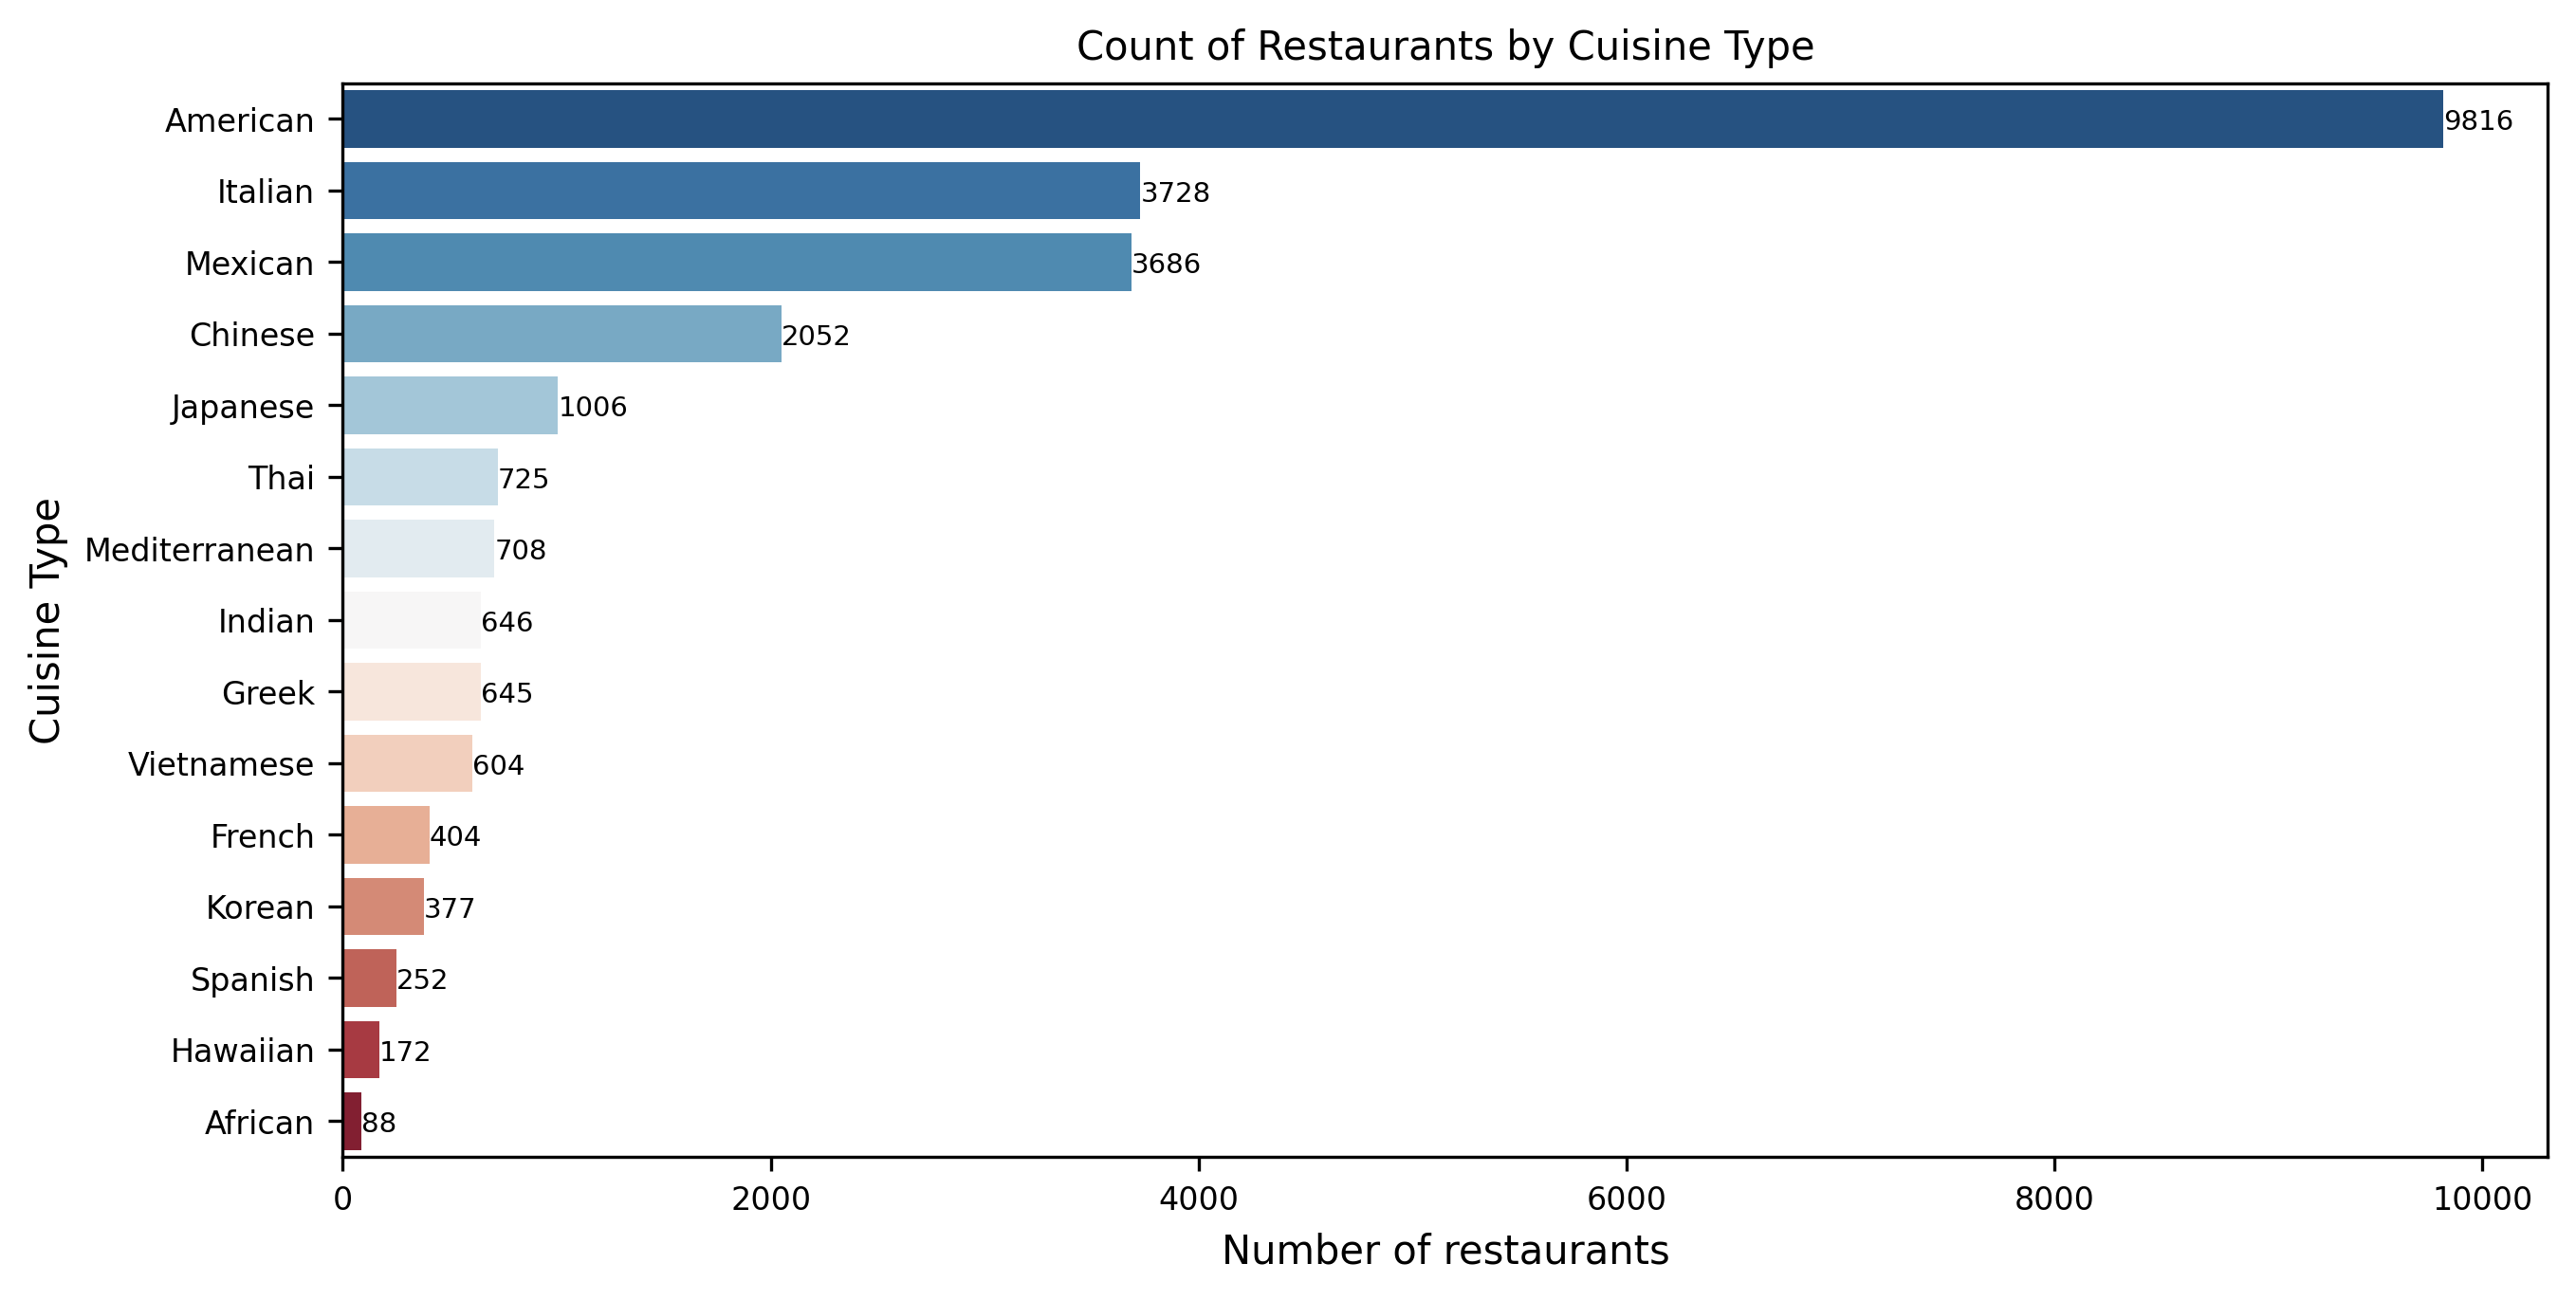

In [ ]:
plt.figure(figsize=(10,5), dpi=300)
grouped = us_restaurants.category.value_counts()
sns.countplot(y='category',data=us_restaurants, 
              order = grouped.index, palette= sns.color_palette("RdBu_r", len(grouped)))
# plt.xlabel('Number of restaurants', fontsize=10, labelpad=10)
plt.xlabel('Number of restaurants')
# plt.ylabel('Category', fontsize=10)
plt.ylabel('Cuisine Type')
plt.title('Count of Restaurants by Cuisine Type', fontsize=10)
plt.tick_params(labelsize=8)
for  i, v in enumerate(us_restaurants.category.value_counts()):
    # plt.text(v, i+0.15, str(v), fontweight='bold', fontsize=7)
    plt.text(v, i+0.15, str(v), fontsize=7)


## Distribution of reviews by cuisine type

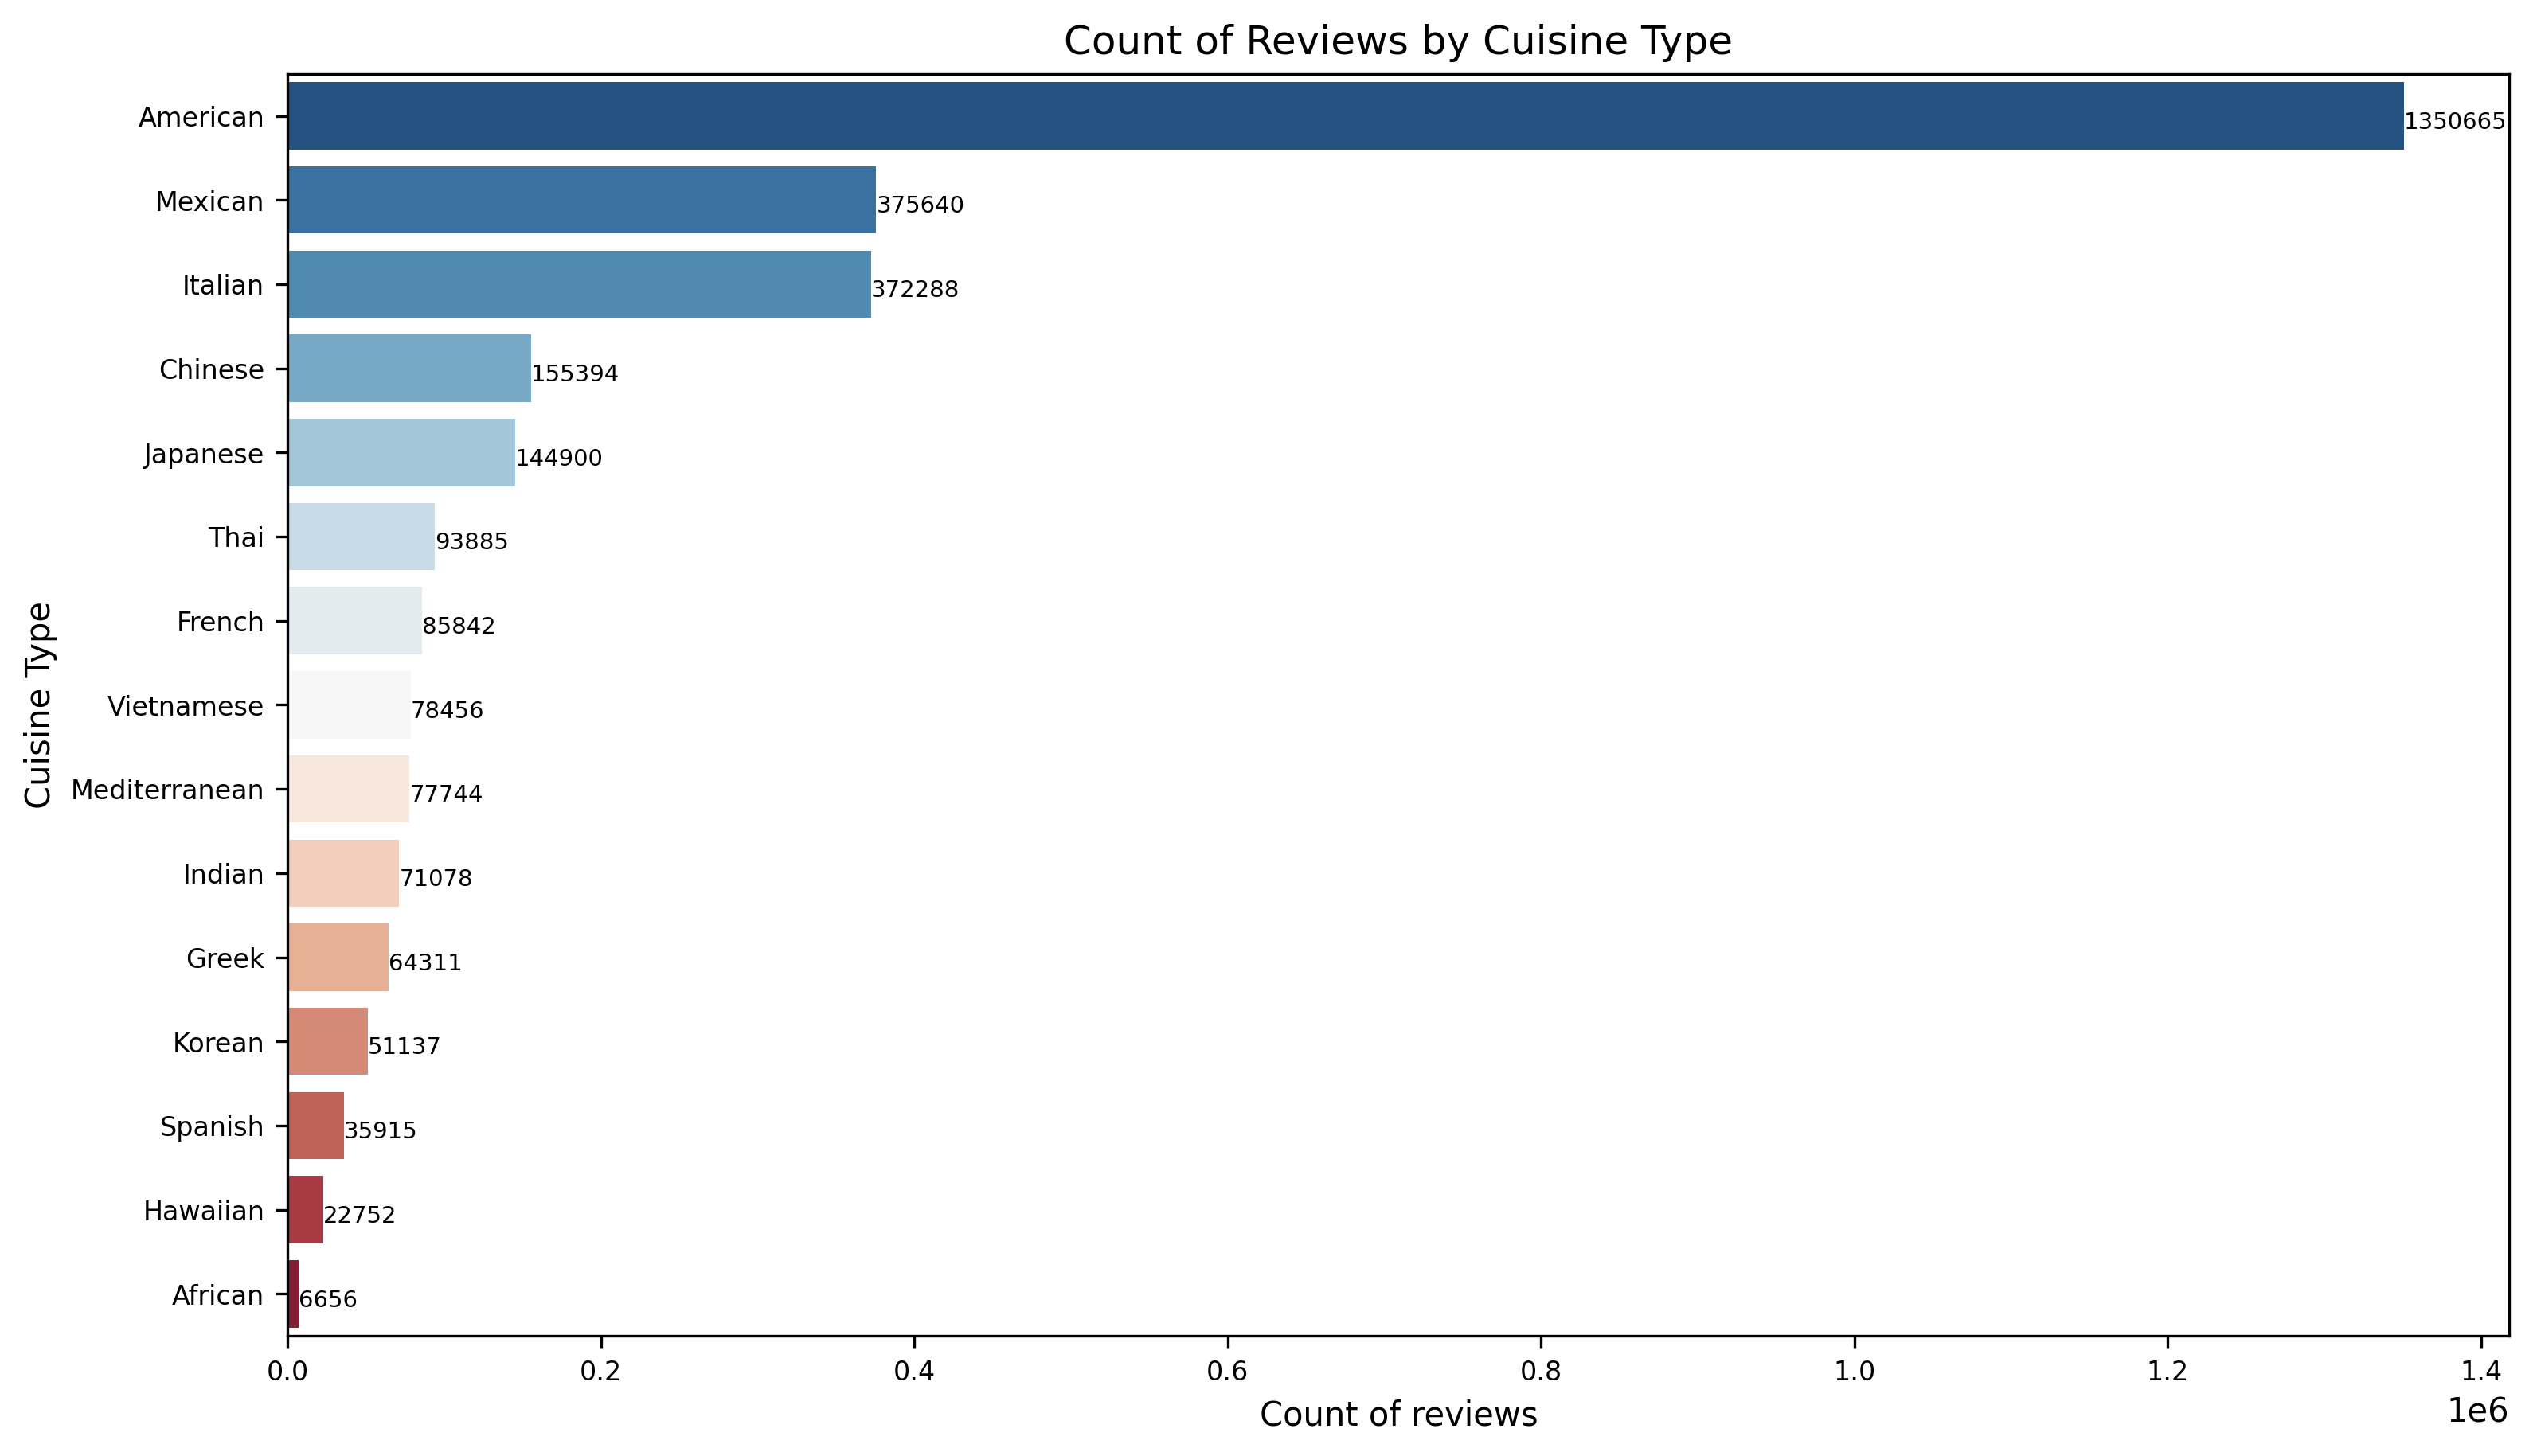

In [ ]:
plt.figure(figsize=(12,7), dpi=300)
grouped = us_restaurants.groupby('category')['review_count'].sum().sort_values(ascending = False)
sns.barplot(y=grouped.index, x= grouped.values, palette= sns.color_palette("RdBu_r", len(grouped)) )
# plt.ylabel('Category', fontsize=14)
# plt.xlabel('Count of reviews', fontsize=14)
# plt.title('Count of Reviews by Cuisine Type', fontsize=15)
plt.ylabel('Cuisine Type')
plt.xlabel('Count of reviews')
plt.title('Count of Reviews by Cuisine Type')
plt.tick_params(labelsize=8)
for i,v in enumerate(grouped):
    # plt.text(v, i+0.15, str(v),fontweight='bold', fontsize=14)
    plt.text(v, i+0.15, str(v), fontsize=7)



## Top 10 cities with most restaurants

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


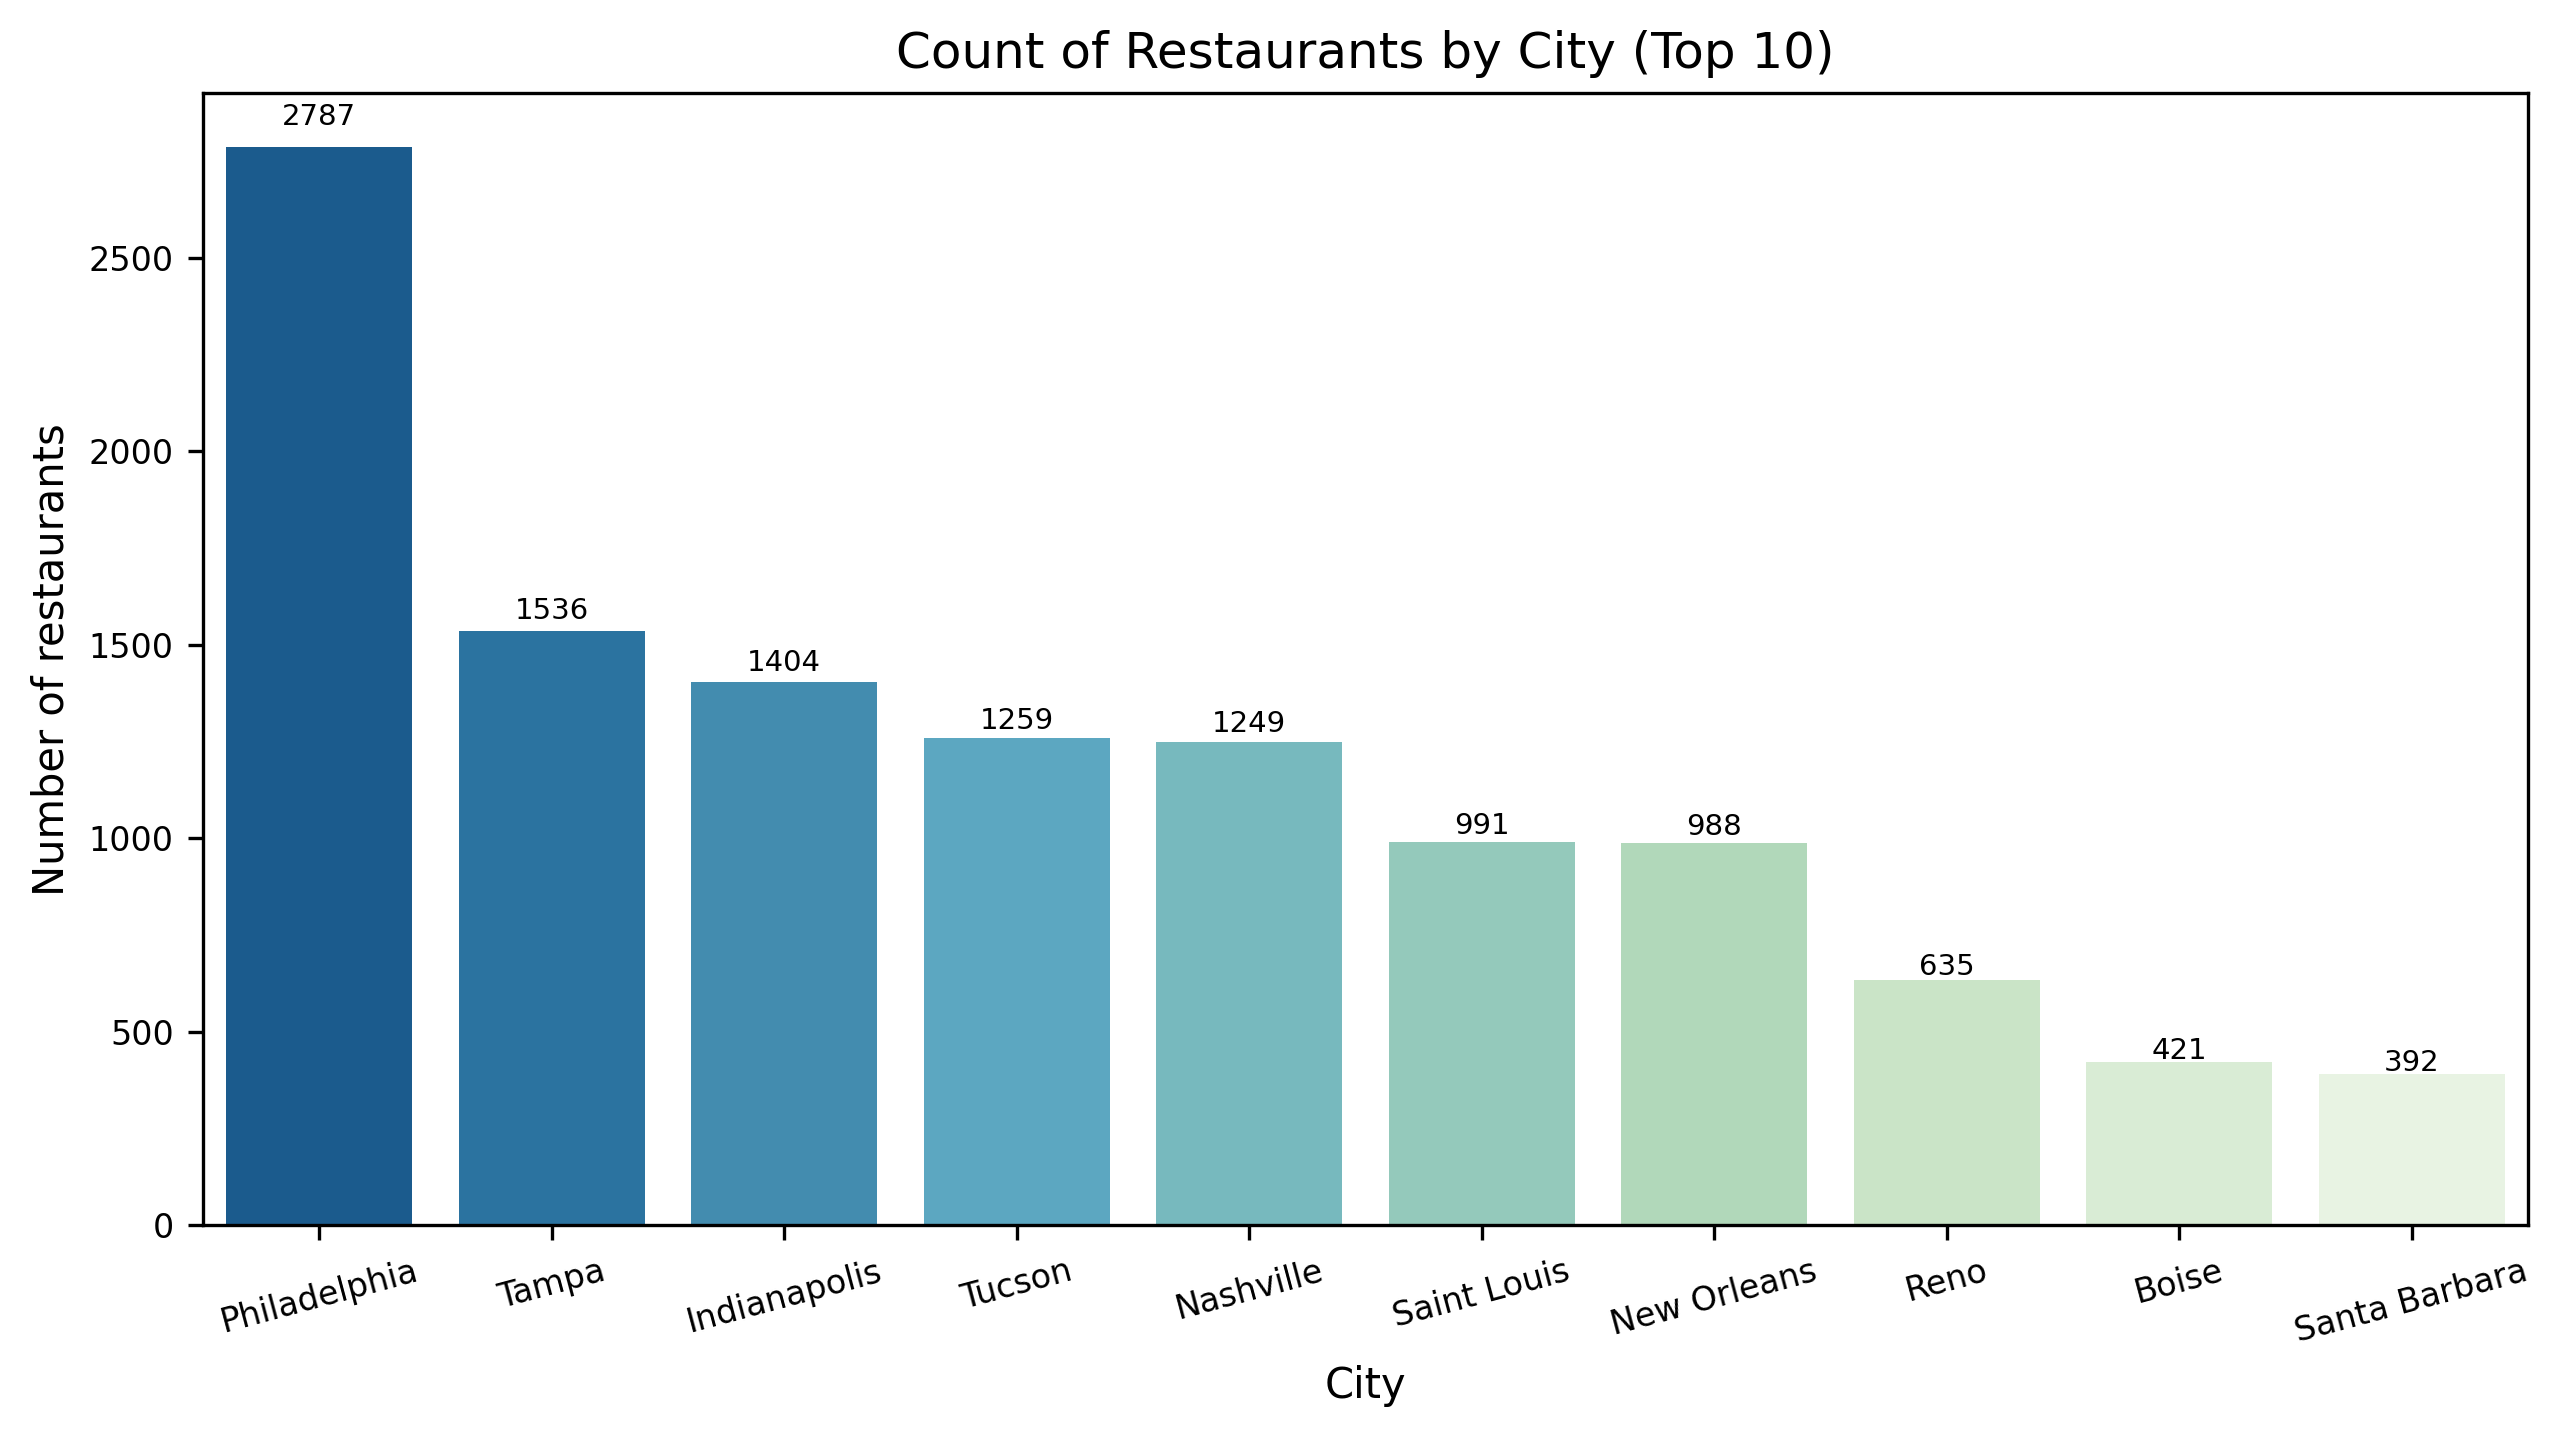

In [ ]:
plt.figure(figsize=(10,5), dpi=300)
grouped = us_restaurants.city.value_counts()[:10]
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)))
# plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.ylabel('Number of restaurants')
# plt.xlabel('City', fontsize=14, labelpad=10)
plt.xlabel('City')
# plt.title('Count of Restaurants by City (Top 10)', fontsize=15)
plt.title('Count of Restaurants by City (Top 10)')
plt.tick_params(labelsize=8)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    # plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    plt.text(i, v*1.02, str(v), horizontalalignment ='center', fontsize=7)

## Distribution of restaurants in each state

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


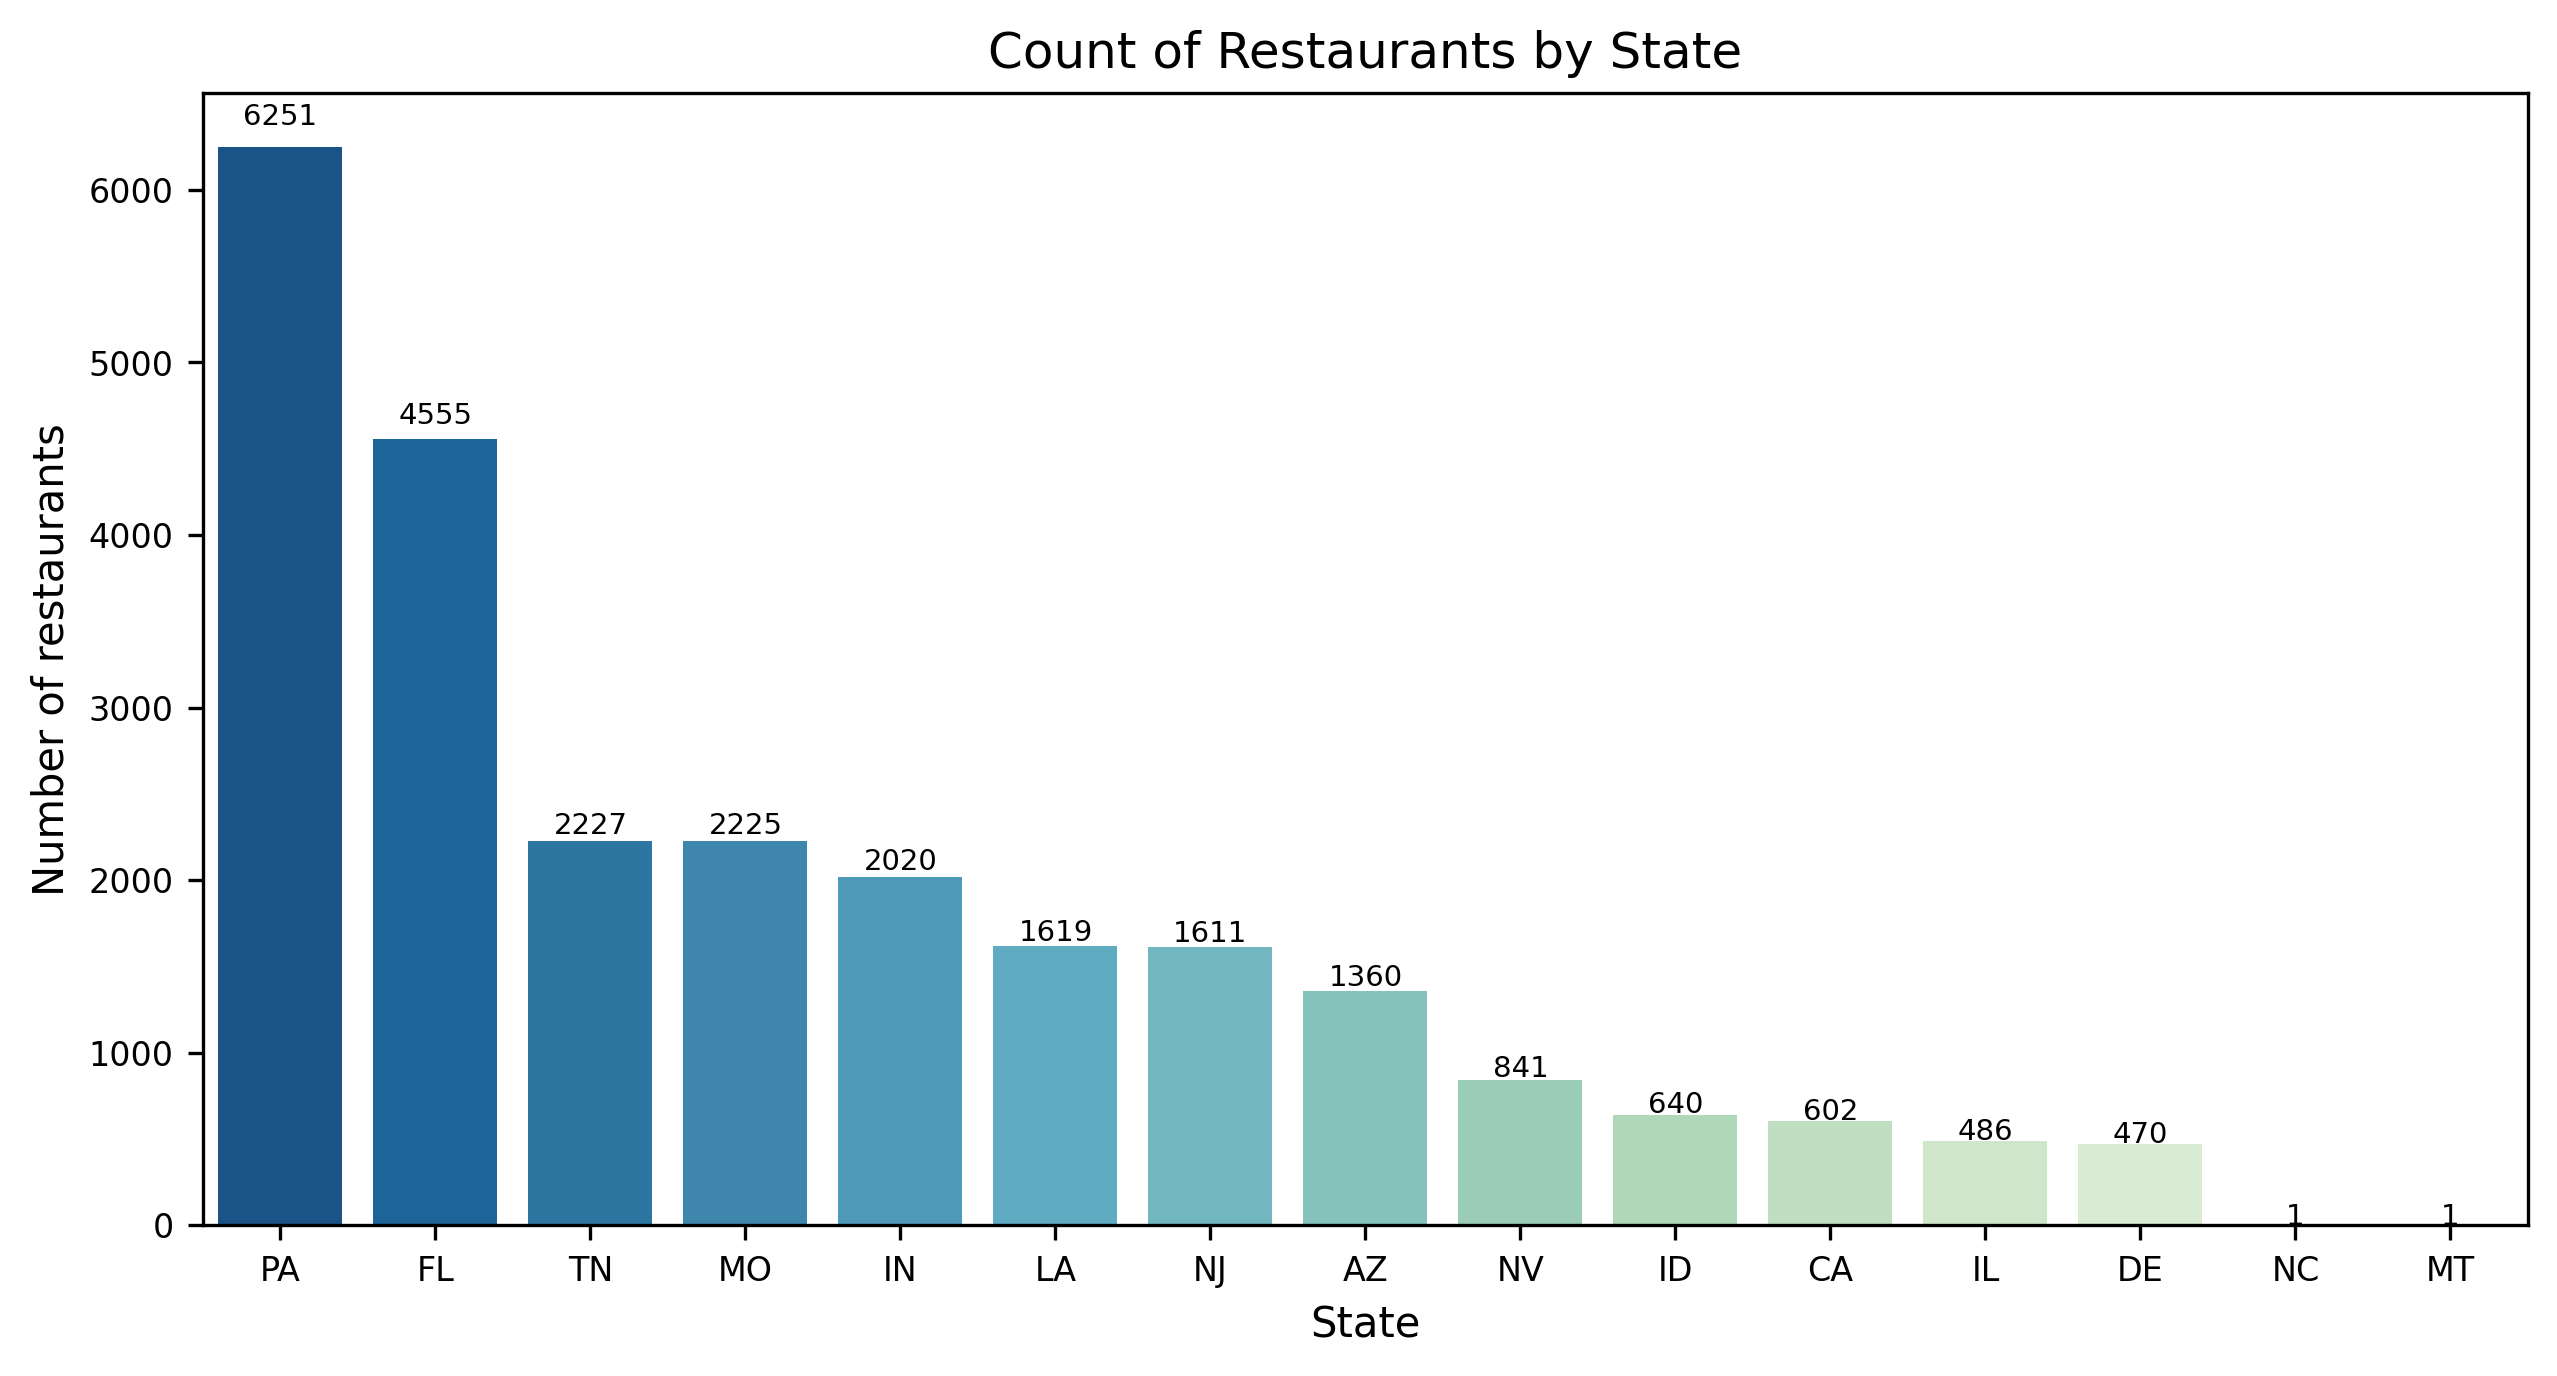

In [ ]:
plt.figure(figsize=(10,5), dpi=300)
grouped = us_restaurants.state.value_counts()
sns.barplot(grouped.index, grouped.values,palette=sns.color_palette("GnBu_r", len(grouped)) )
# plt.ylabel('Number of restaurants', fontsize=14)
plt.ylabel('Number of restaurants')
# plt.xlabel('State', fontsize=14)
plt.xlabel('State')
# plt.title('Count of Restaurants by State', fontsize=15)
plt.title('Count of Restaurants by State')
plt.tick_params(labelsize=8)
for  i, v in enumerate(grouped):
    # plt.text(i, v*1.02, str(v), horizontalalignment ='center', fontweight='bold', fontsize=14)
    plt.text(i, v*1.02, str(v), horizontalalignment ='center', fontsize=7)


## Top 10 cities with most reviews

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


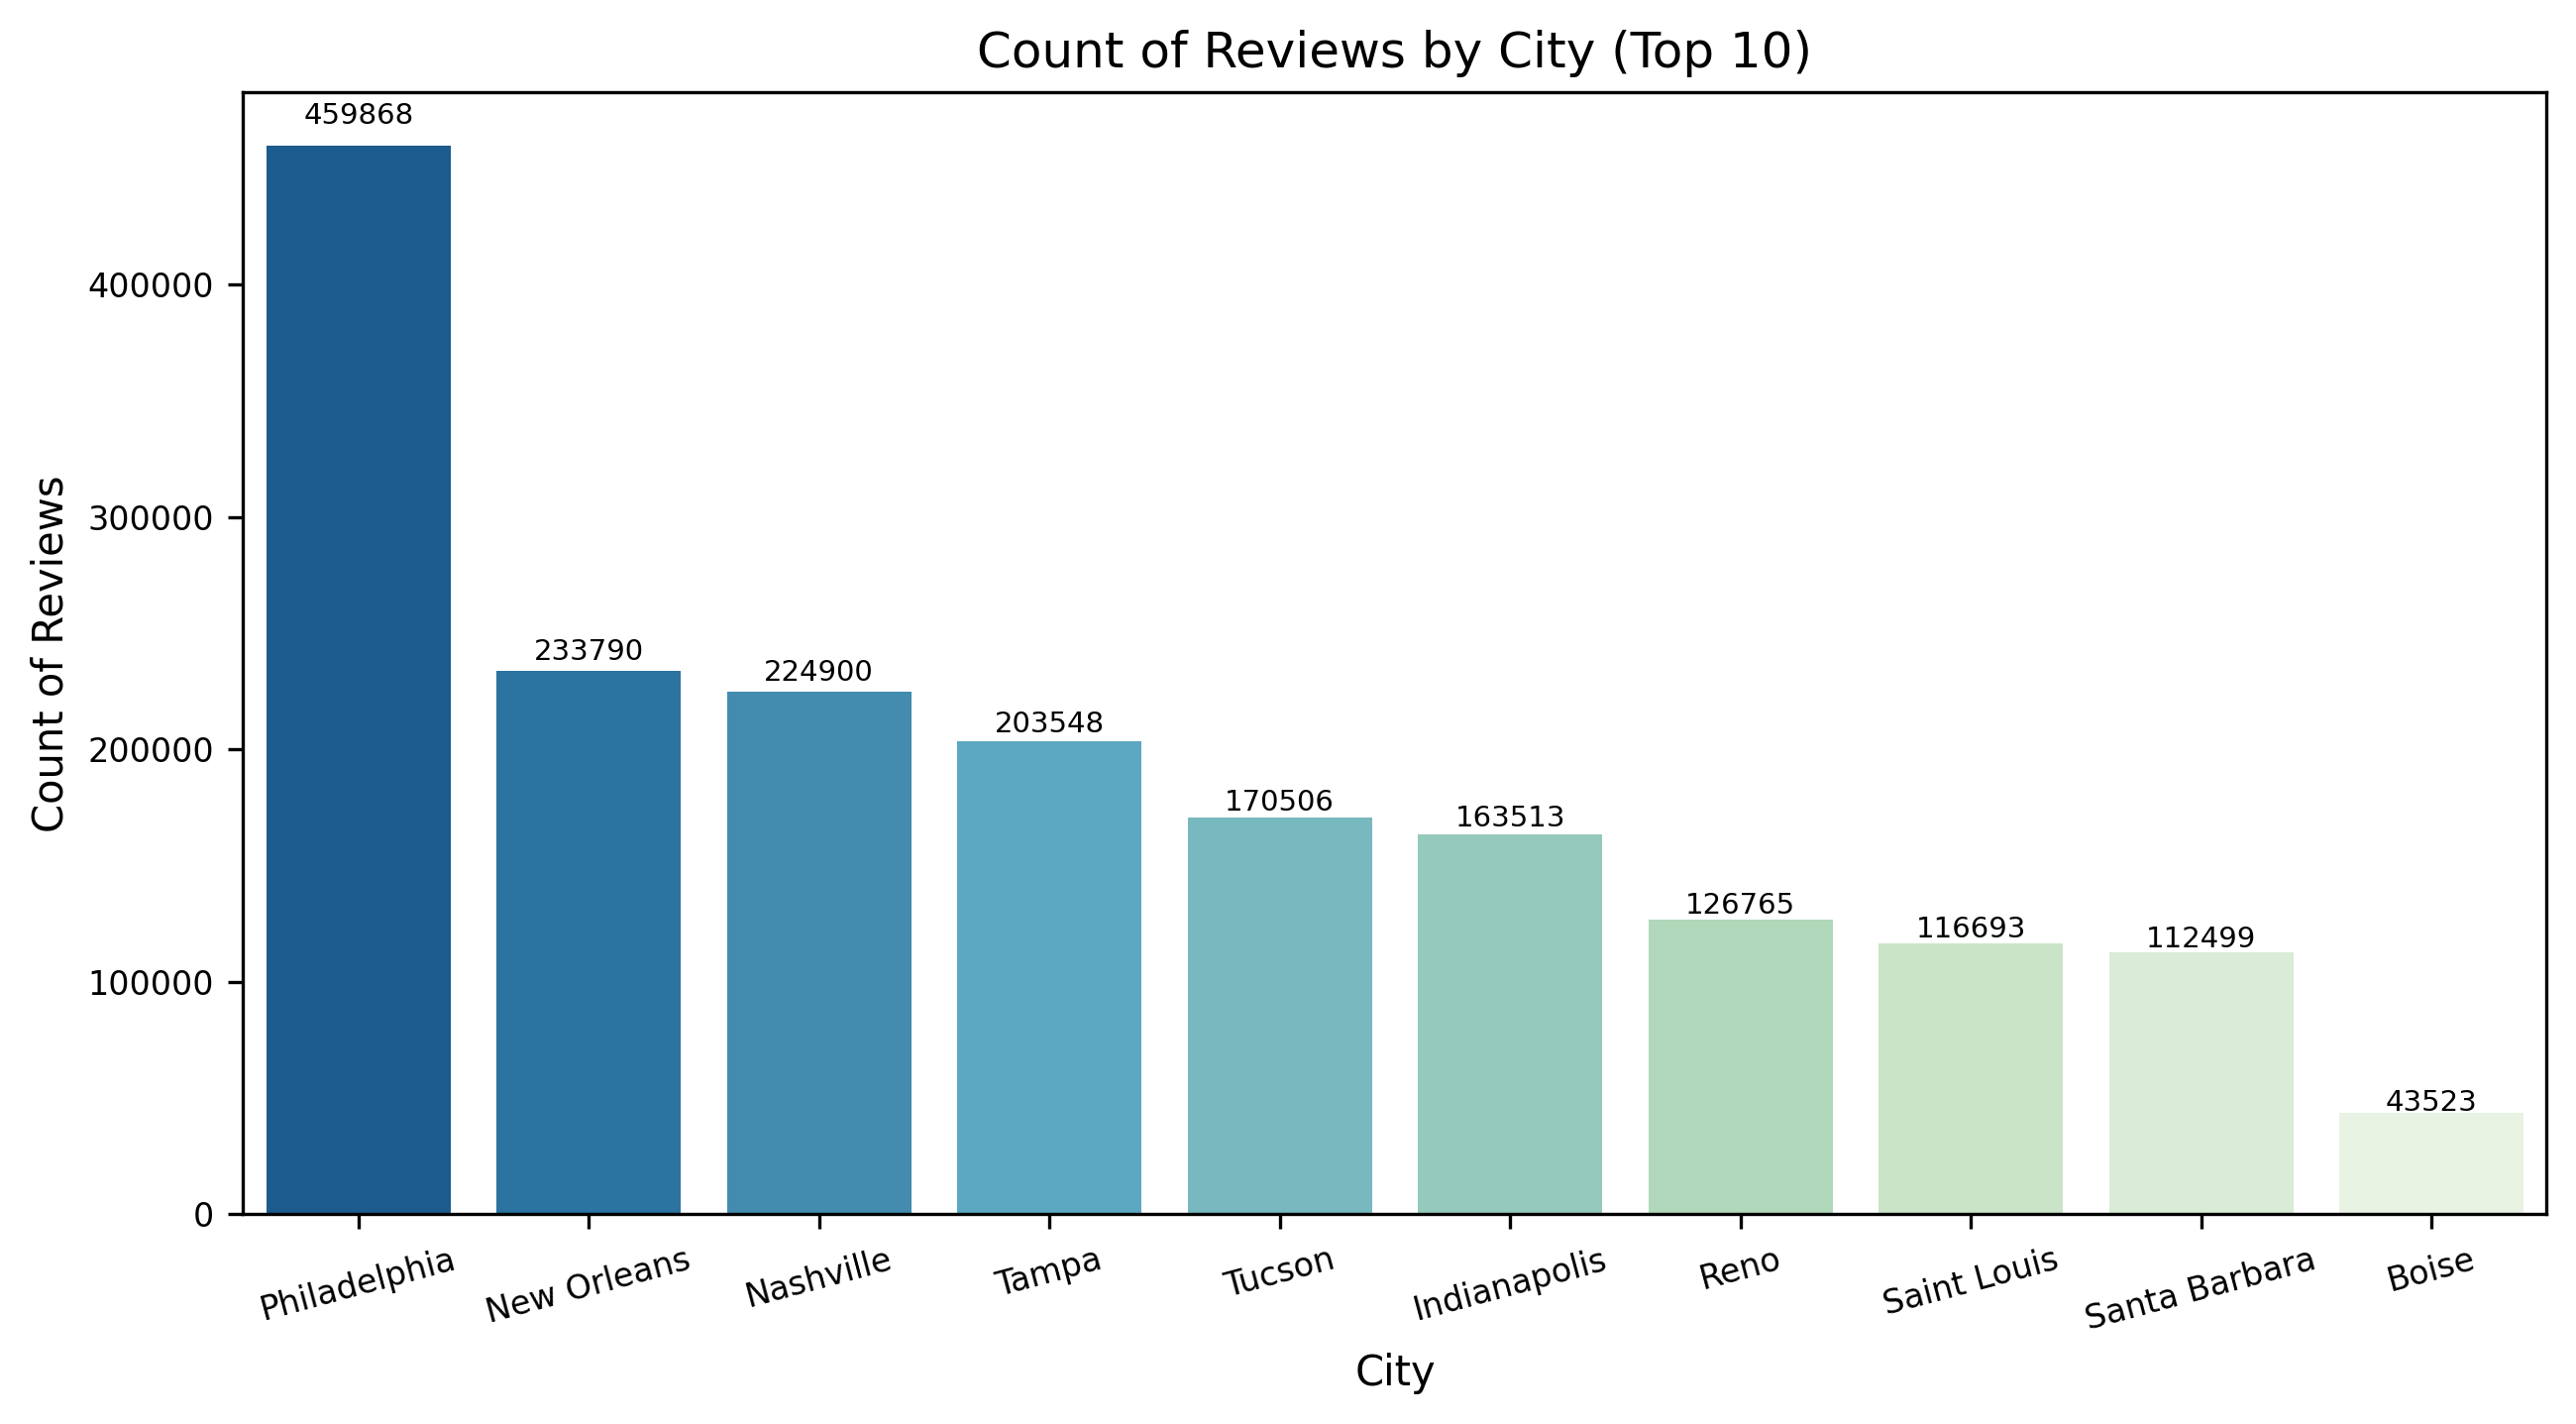

In [ ]:
plt.figure(figsize=(10,5), dpi=300)
grouped = us_restaurants.groupby('city')['review_count'].sum().sort_values(ascending=False)[:10]
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)) )
# plt.xlabel('City', labelpad=10, fontsize=14)
# plt.ylabel('Count', fontsize=14)
# plt.title('Count of Reviews by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=8)
plt.xlabel('City')
plt.ylabel('Count of Reviews')
plt.title('Count of Reviews by City (Top 10)')
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    # plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    plt.text(i, v*1.02, str(v), horizontalalignment ='center', fontsize=7)


## Top 10 restaurants with most reviews

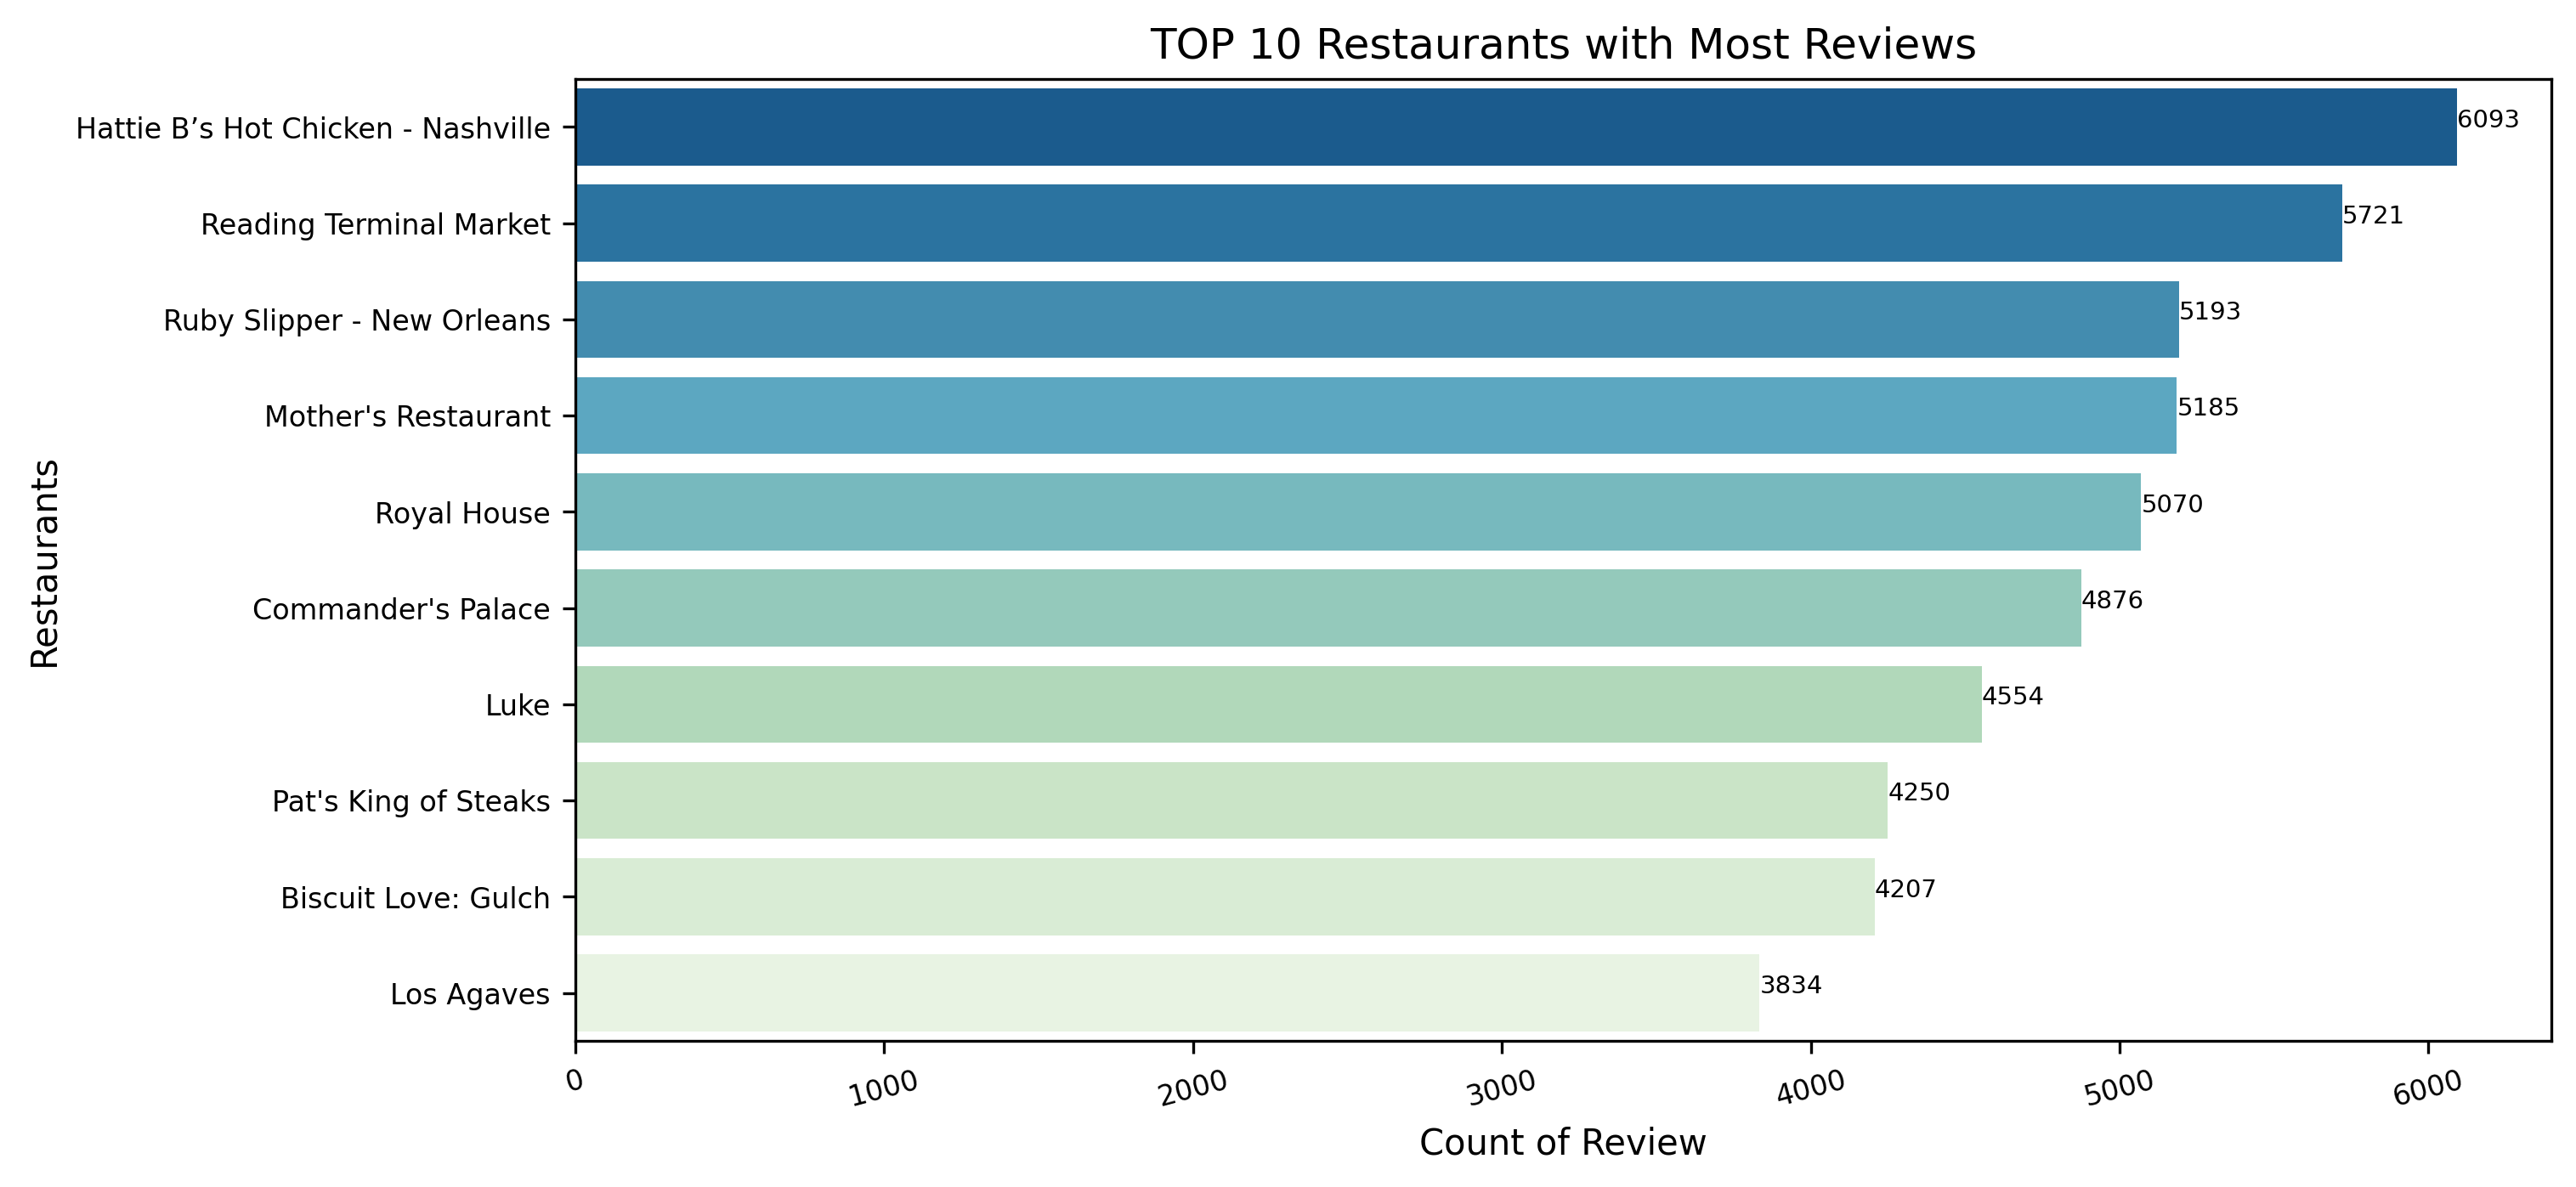

In [ ]:
plt.figure(figsize=(10,5), dpi=300)
grouped = us_restaurants[['name','review_count']].sort_values(by='review_count', ascending=False)[:10]
sns.barplot(x=grouped.review_count, y = grouped.name, palette=sns.color_palette("GnBu_r", len(grouped)), ci=None)
# plt.xlabel('Count of Review', labelpad=10, fontsize=14)
# plt.ylabel('Restaurants', fontsize=14)
# plt.title('TOP 10 Restaurants with Most Reviews', fontsize=15)
plt.tick_params(labelsize=8)
plt.xlabel('Count of Review')
plt.ylabel('Restaurants')
plt.title('TOP 10 Restaurants with Most Reviews')
plt.xticks(rotation=15)
for  i, v in enumerate(grouped.review_count):
    # plt.text(v, i, str(v), fontweight='bold', fontsize=14)
    plt.text(v, i, str(v), fontsize=7)


## Distribution of positive and negative reviews in each category

In [ ]:
table = pd.pivot_table(restaurants_reviews, values=["review_id"], index=["category"],columns=["labels"], 
                       aggfunc=len, margins=True, dropna=True,fill_value=0)
table_percentage = table.div( table.iloc[:,-1], axis=0).iloc[:-1,-2].sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


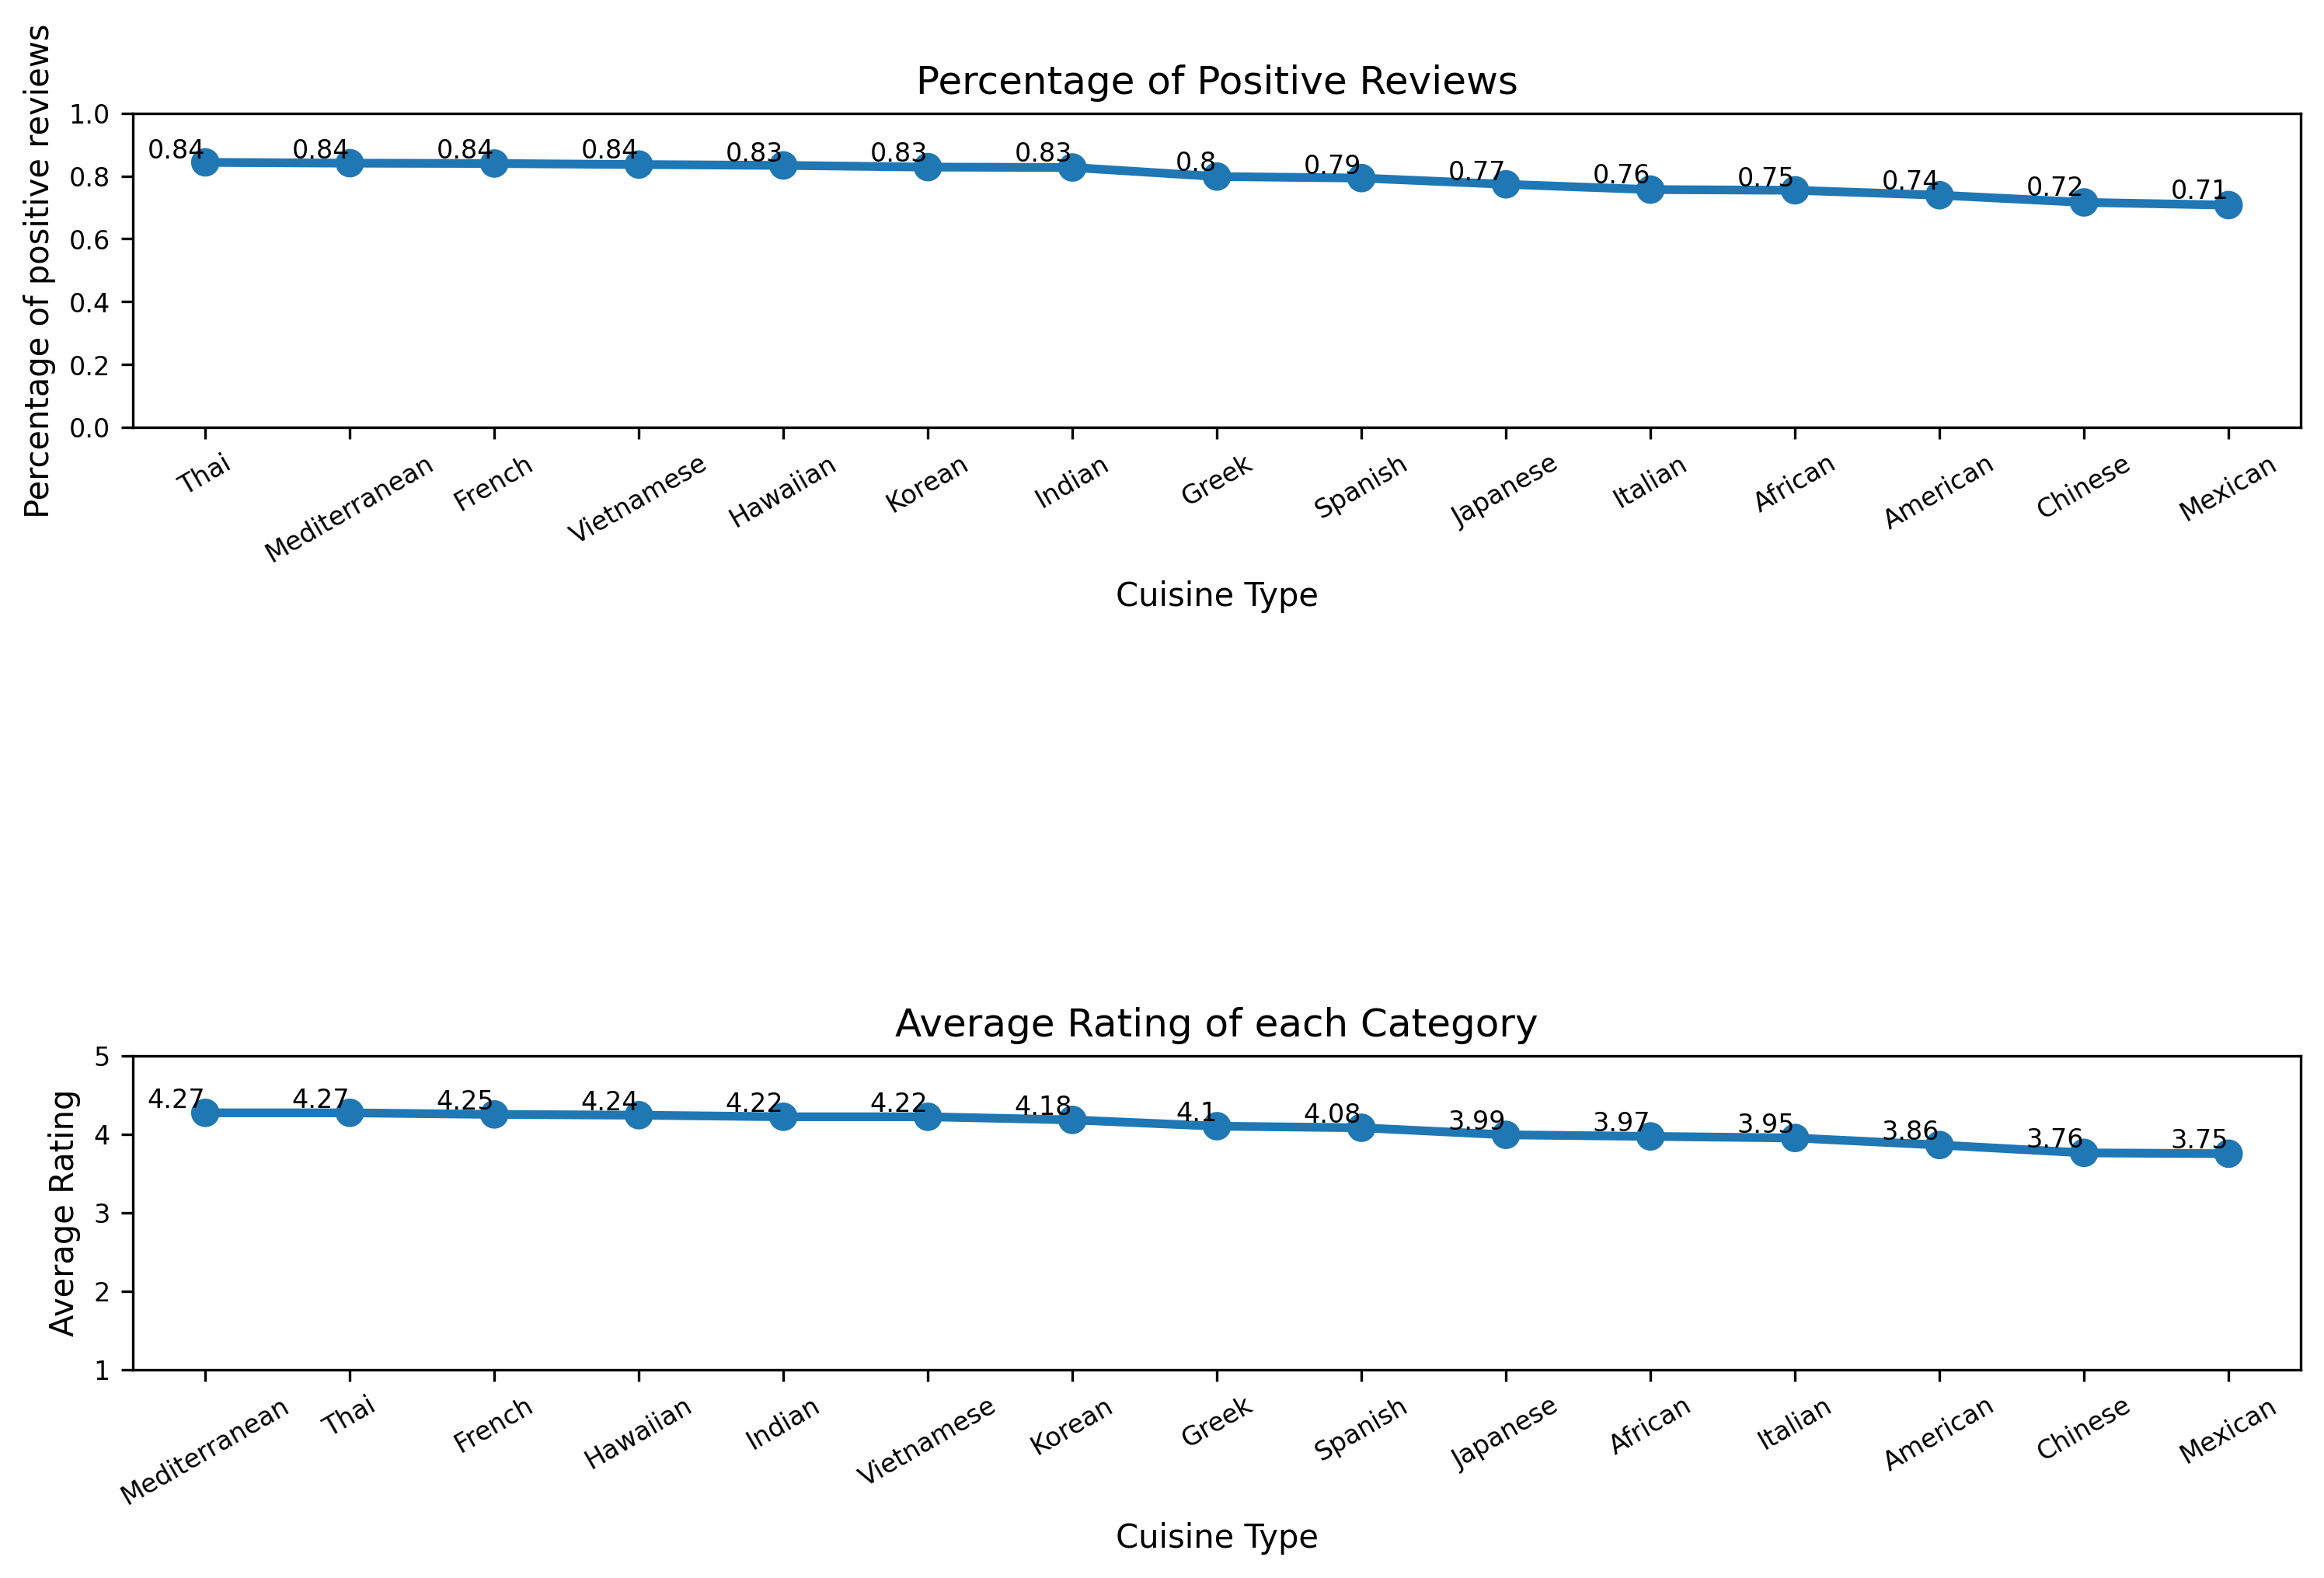

In [ ]:
table = pd.pivot_table(restaurants_reviews, values=["review_id"], index=["category"],columns=["labels"], 
                       aggfunc=len, margins=True, 
                       dropna=True,fill_value=0)

table_percentage = table.div( table.iloc[:,-1], axis=0).iloc[:-1,-2].sort_values(ascending=False)
plt.figure(figsize=(12,7), dpi=300)
plt.subplot(211)

sns.pointplot(x=table_percentage.index, y= table_percentage.values)

# plt.xlabel('Category', labelpad=5, fontsize=15)
# plt.ylabel('Percentage of positive reviews', fontsize=15)
# plt.title('Percentage of Positive Reviews', fontsize=15)
plt.tick_params(labelsize=8)
plt.ylim(0.00, 1.00)
plt.xlabel('Cuisine Type')
plt.ylabel('Percentage of positive reviews')
plt.title('Percentage of Positive Reviews')
plt.xticks(rotation=30)
for  i, v in enumerate(table_percentage.round(2)):
    # plt.text(i, v*1.001, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    plt.text(i, v, str(v), horizontalalignment ='right', verticalalignment ='bottom', fontsize=8)

    
plt.subplot(212)
grouped = restaurants_reviews.groupby('category')['review_star'].mean().round(2).sort_values(ascending=False)

sns.pointplot(grouped.index, grouped.values)
plt.ylim(float(1.0),float(5.0))
# plt.xlabel('Category', labelpad=5, fontsize=12)
# plt.ylabel('Average Rating', fontsize=12)
# plt.title('Average Rating of each Category', fontsize=12)
plt.tick_params(labelsize=8)
plt.xlabel('Cuisine Type')
plt.ylabel('Average Rating')
plt.title('Average Rating of each Category')
plt.xticks(rotation=30)
for  i, v in enumerate(grouped):
    # plt.text(i, v, str(v), horizontalalignment ='center',fontweight='bold', fontsize=12)
    plt.text(i, v, str(v), horizontalalignment ='right', verticalalignment ='bottom',fontsize=8)

    
plt.subplots_adjust(hspace=2)

## Average length of words in each category

Text(0.5, 1.0, 'Average length of words by Cuisine Type')

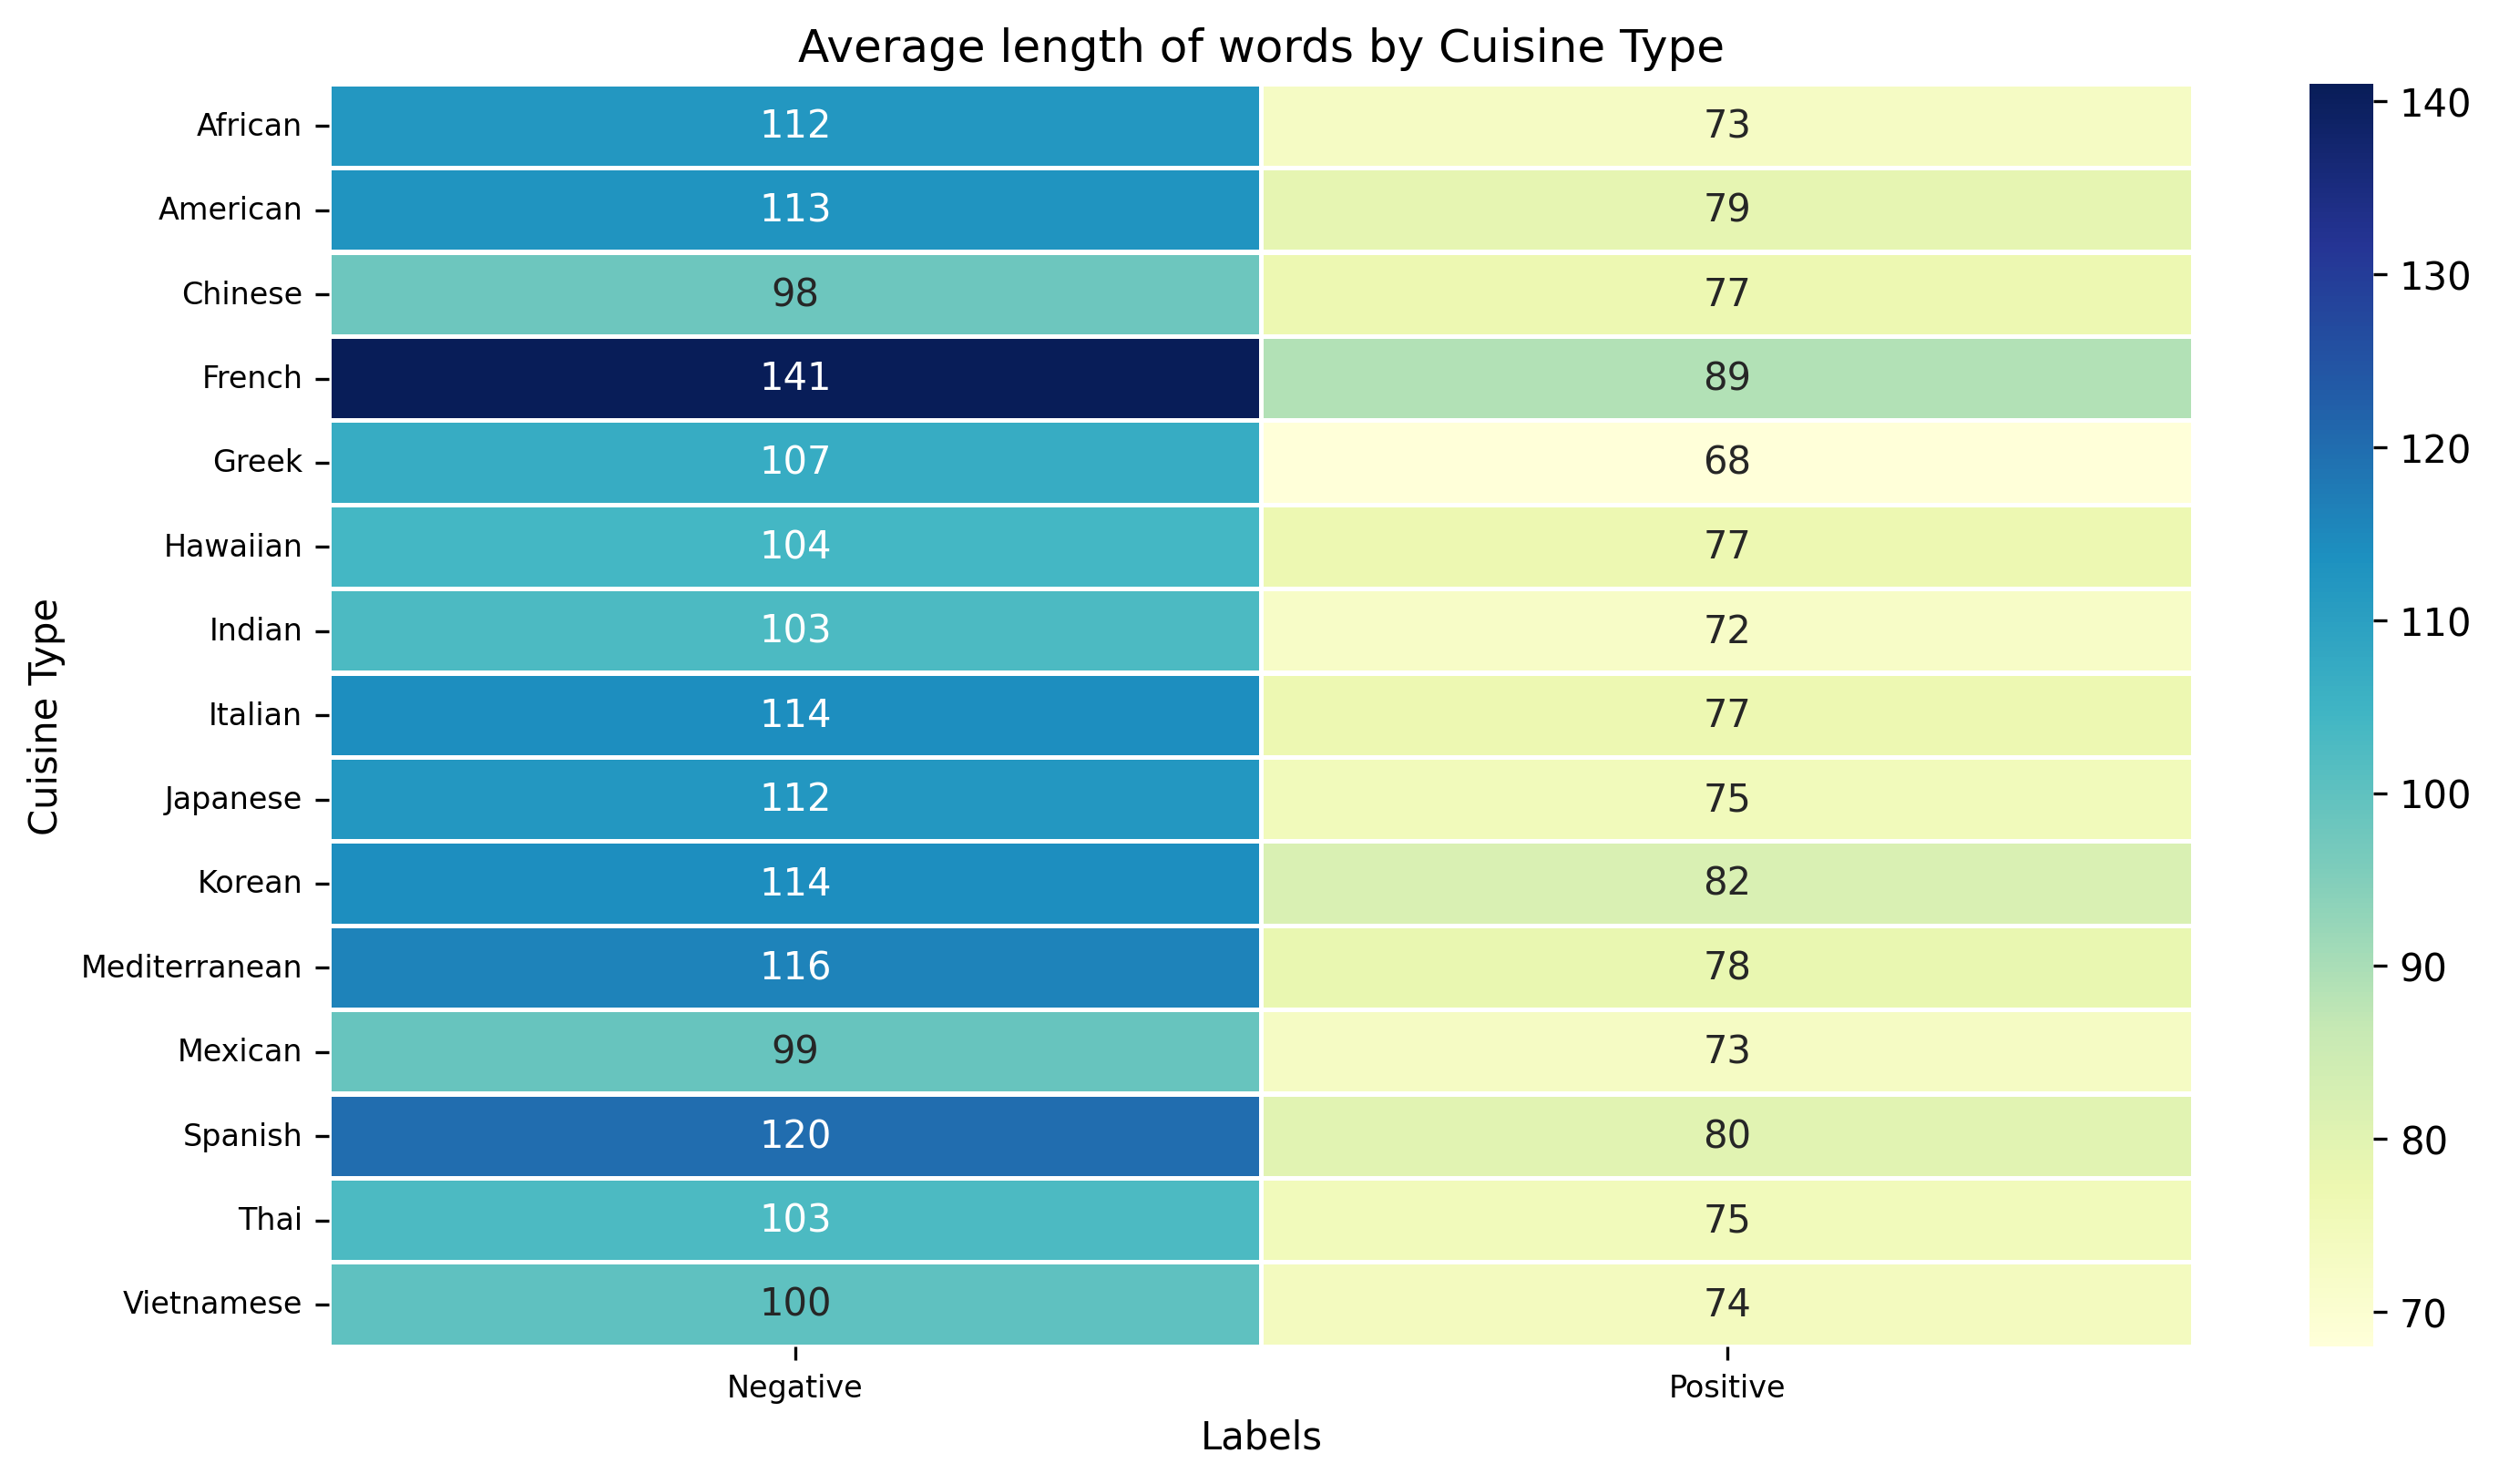

In [ ]:
table = restaurants_reviews.groupby(['category','labels'])['num_words_review'].mean().round().unstack()
plt.figure(figsize=(11,6), dpi=300)
sns.heatmap(table, cmap='YlGnBu', fmt='g',annot=True, linewidths=1)
plt.tick_params(labelsize=8)
plt.xlabel('Labels')
plt.ylabel('Cuisine Type')
plt.title('Average length of words by Cuisine Type')

##Distribution of ratings by restaurants

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



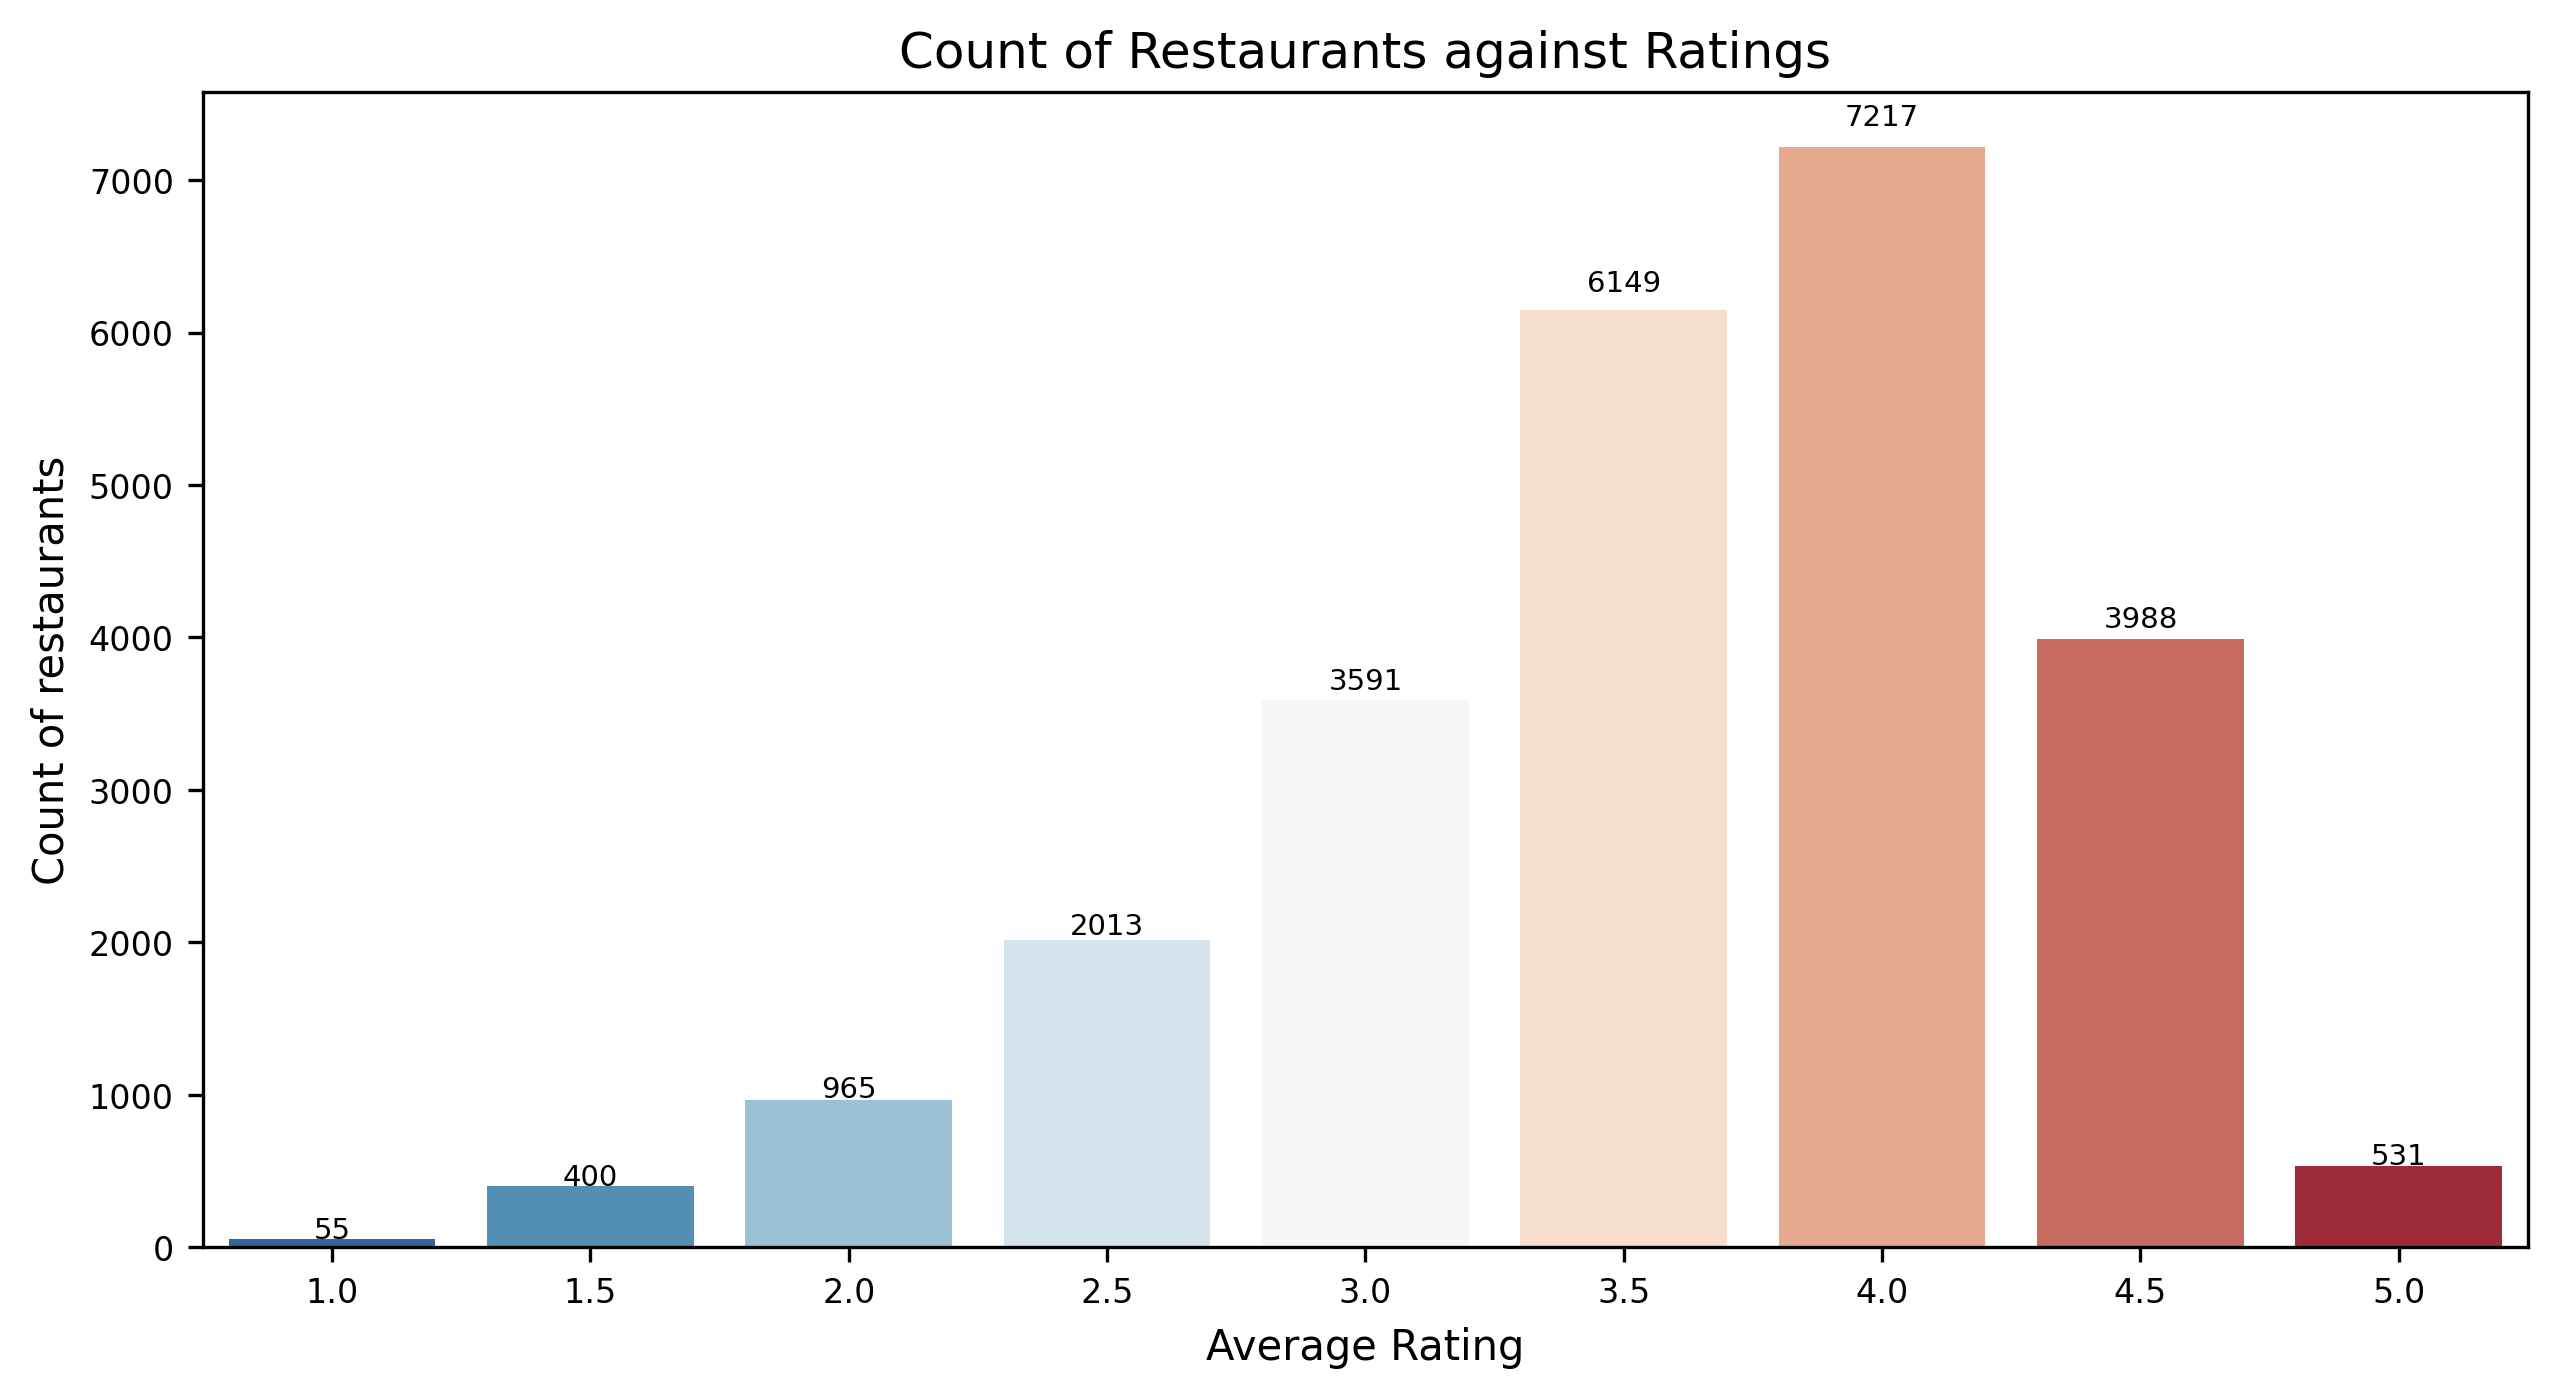

In [ ]:
plt.figure(figsize=(10,5), dpi=300)
grouped = us_restaurants.stars.value_counts().sort_index()
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
# plt.xlabel('Average Rating', labelpad=10, fontsize=14)
# plt.ylabel('Count of restaurants', fontsize=14)
# plt.title('Count of Restaurants against Ratings', fontsize=15)
plt.tick_params(labelsize=8)
plt.xlabel('Average Rating')
plt.ylabel('Count of restaurants')
plt.title('Count of Restaurants against Ratings')
# plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    # plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    plt.text(i, v*1.02, str(v), horizontalalignment ='center', fontsize=7)


##Distribution of ratings by reviews

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



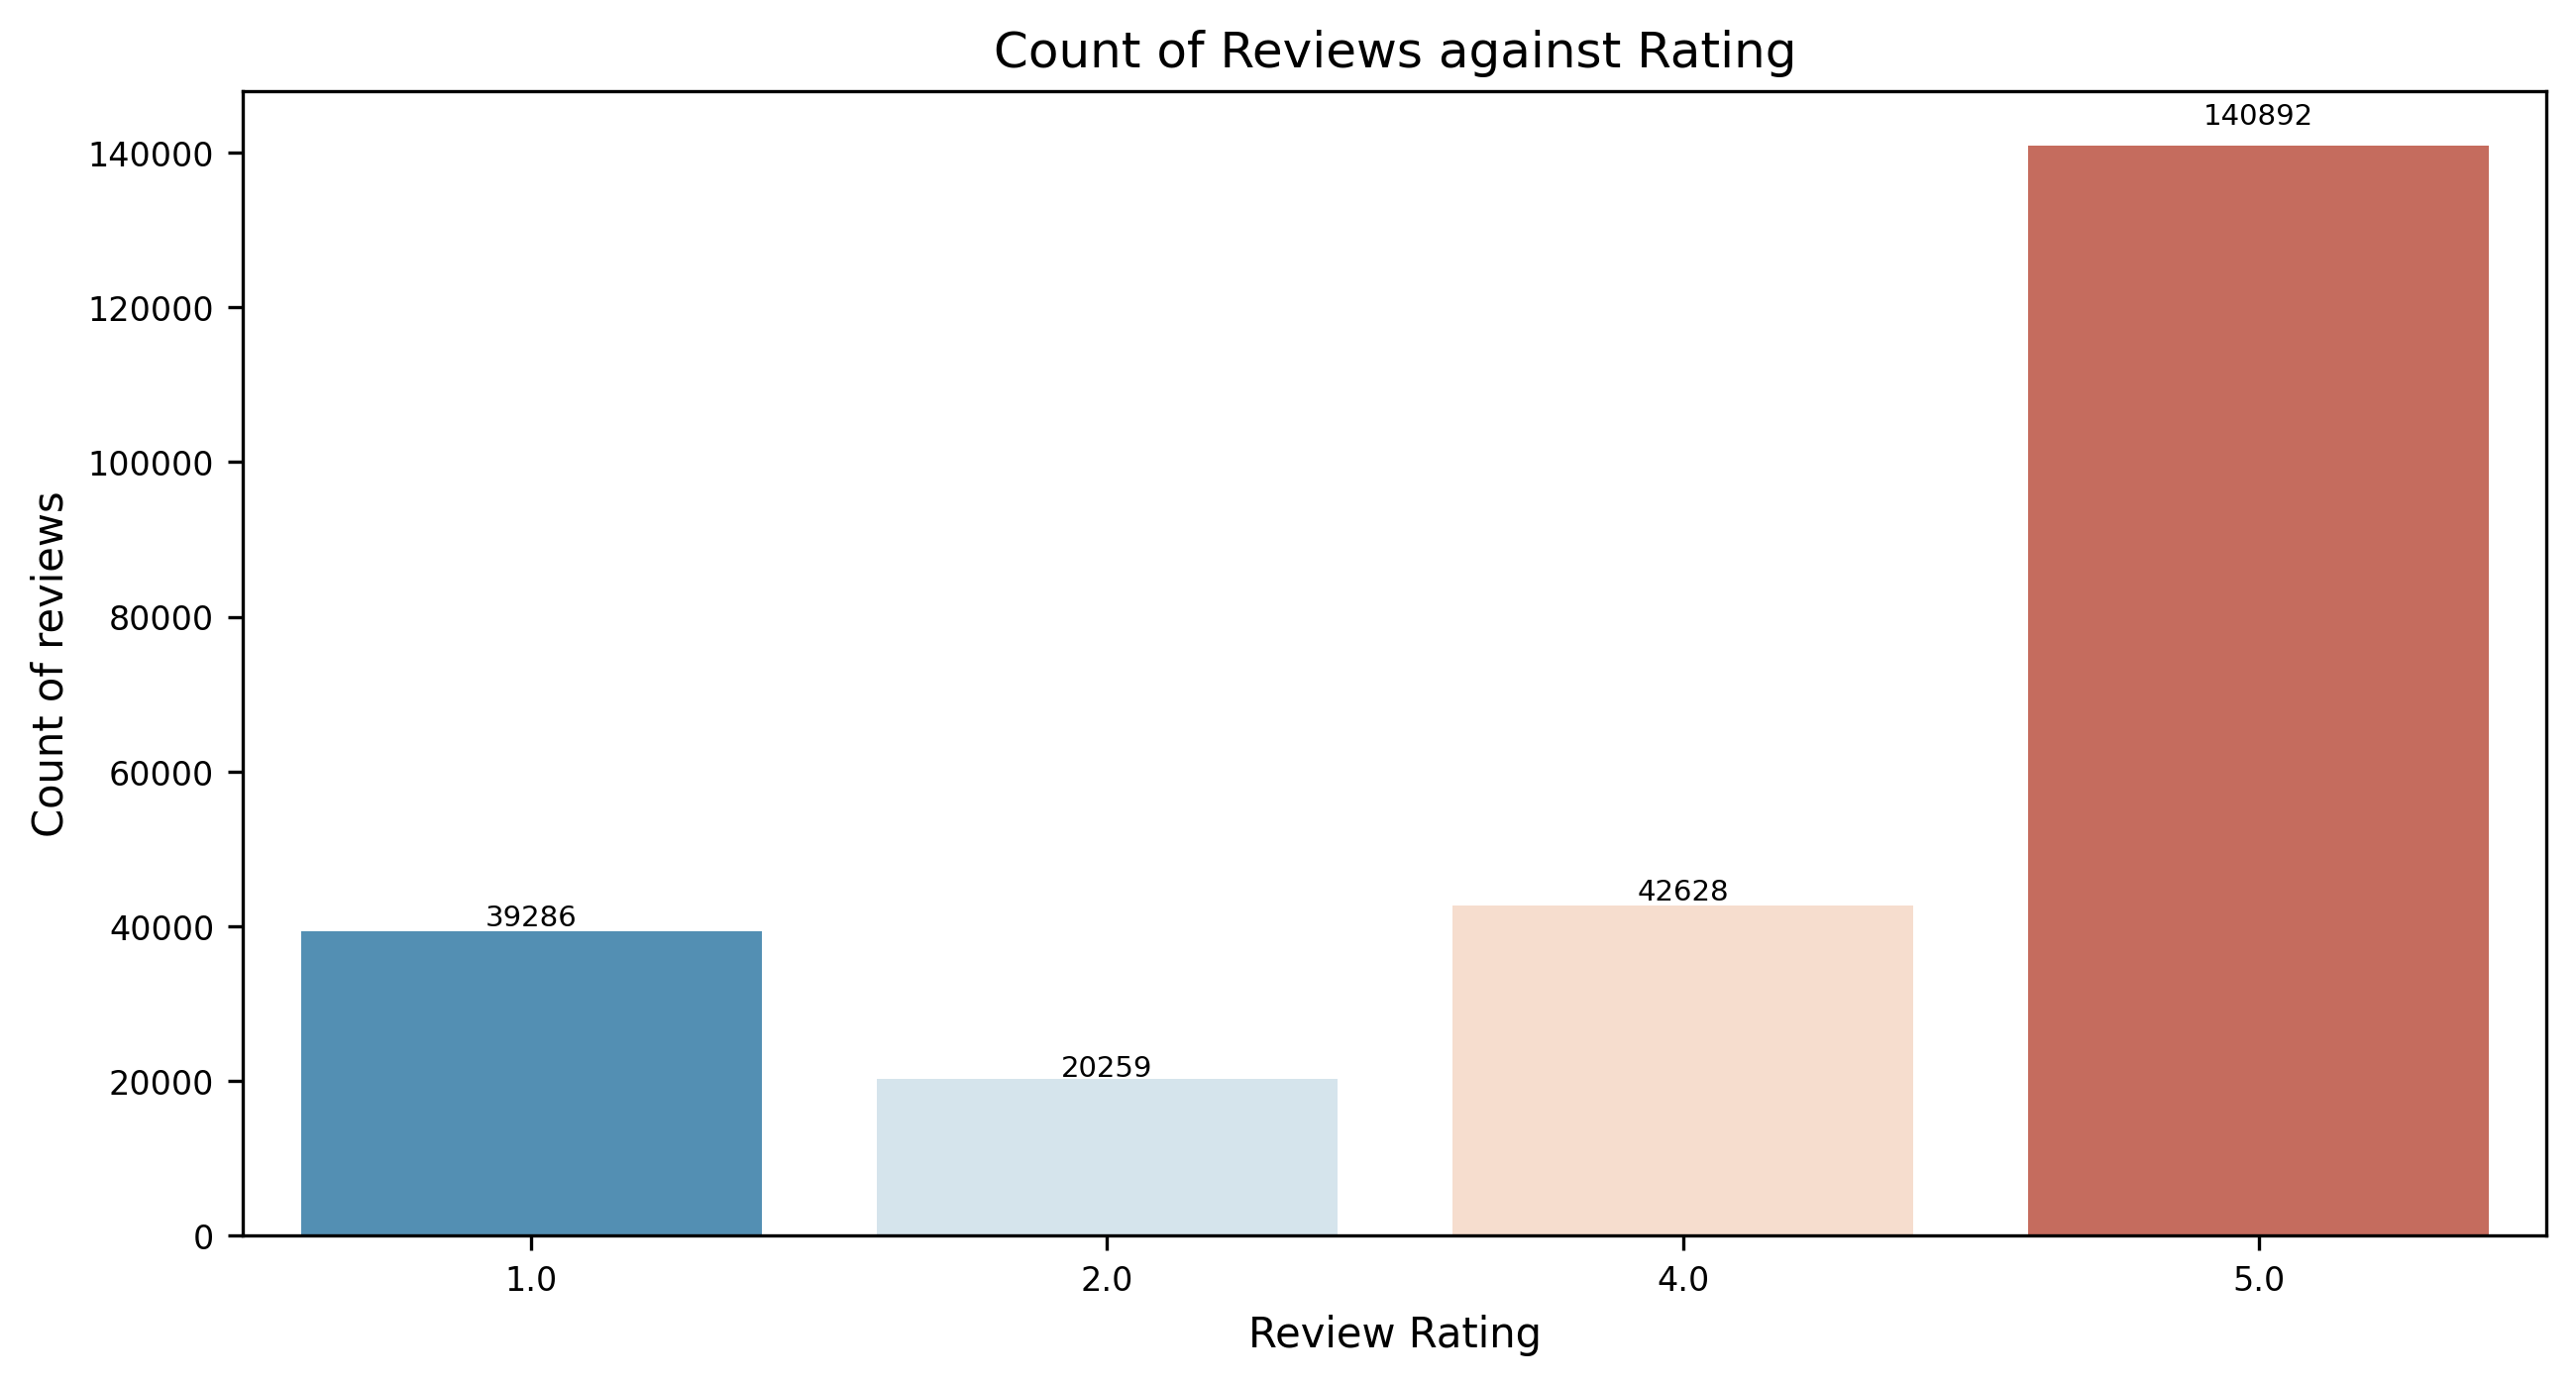

In [ ]:
plt.figure(figsize=(10,5), dpi=300)
grouped = restaurants_reviews.review_star.value_counts().sort_index()
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
# plt.xlabel('Review Rating', labelpad=5, fontsize=12)
# plt.ylabel('Count of reviews', fontsize=12)
# plt.title('Count of Reviews against Rating', fontsize=12)
plt.tick_params(labelsize=8)
plt.xlabel('Review Rating')
plt.ylabel('Count of reviews')
plt.title('Count of Reviews against Rating')
for  i, v in enumerate(grouped):
    # plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=12)
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontsize=7)


## Positive words and negative words

In [ ]:
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score,\
    precision_score, f1_score, roc_auc_score
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [ ]:
## convert text to lower case
restaurants_reviews.text = restaurants_reviews.text.str.lower()

## remove unnecessary punctuation
restaurants_reviews['removed_punct_text']= restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning:

The default value of regex will change from True to False in a future version.



In [ ]:
## import positive file which contains common meaningless positive words such as good
file_positive = open('positive.txt')
reader =csv.reader(file_positive)
positive_words = [word[0] for word in reader]

## import negative file which contains common meaningless positive words such as bad
file_negative = open('negative.txt')
reader =csv.reader(file_negative)
negative_words = [word[0] for word in reader]

##Polarity Score

In [ ]:
## get dataset by category
def get_dataset(category):
    df = restaurants_reviews[['removed_punct_text','labels']][restaurants_reviews.category==category]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    return df

## only keep positive and negative words
def filter_words(review):
    words = [word for word in review.split() if word in positive_words + negative_words]
    words = ' '.join(words)
    return words

In [ ]:
def get_polarity_score(dataset):
    dataset.text = dataset.text.apply(filter_words)
    
    terms_train=list(dataset['text'])
    class_train=list(dataset['labels'])
    
    ## get bag of words
    vectorizer = CountVectorizer()
    feature_train_counts=vectorizer.fit_transform(terms_train)
    
    ## run model
    svm = LinearSVC()
    svm.fit(feature_train_counts, class_train)
    
    ## create dataframe for score of each word in a review calculated by svm model
    coeff = svm.coef_[0]
    cuisine_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})
    
    ## get frequency of each word in all reviews in specific category
    cuisine_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names())
    cuisine_reviews['labels'] = class_train
    cuisine_frequency = cuisine_reviews[cuisine_reviews['labels'] =='positive'].sum()[:-1]
    
    cuisine_words_score.set_index('word', inplace=True)
    cuisine_polarity_score = cuisine_words_score
    cuisine_polarity_score['frequency'] = cuisine_frequency
    
    cuisine_polarity_score.score = cuisine_polarity_score.score.astype(float)
    cuisine_polarity_score.frequency = cuisine_polarity_score.frequency.astype(int)
    
    ## calculate polarity score 
    cuisine_polarity_score['polarity'] = cuisine_polarity_score.score * cuisine_polarity_score.frequency / cuisine_reviews.shape[0]
    
    cuisine_polarity_score.polarity = cuisine_polarity_score.polarity.astype(float)
    ## drop unnecessary words
    unuseful_positive_words = ['great','amazing','love','best','awesome','excellent','good',
                                                   'favorite','loved','perfect','gem','perfectly','wonderful',
                                                    'happy','enjoyed','nice','well','super','like','better','decent','fine',
                                                    'pretty','enough','excited','impressed','ready','fantastic','glad','right',
                                                    'fabulous']
    unuseful_negative_words =  ['bad','disappointed','unfortunately','disappointing','horrible',
                                                    'lacking','terrible','sorry']

    unuseful_words = unuseful_positive_words + unuseful_negative_words
    cuisine_polarity_score.drop(cuisine_polarity_score.loc[unuseful_words].index, axis=0, inplace=True)
    
    return cuisine_polarity_score

In [ ]:
def plot_top_words(top_words, category):
    plt.figure(figsize=(11,6), dpi=300)
    colors = ['pink' if c < 0 else 'purple' for c in top_words.values]
    sns.barplot(y=top_words.index, x=top_words.values, palette=colors)
    # plt.xlabel('Polarity Score', labelpad=10, fontsize=12)
    # plt.ylabel('Words', fontsize=12)
    # plt.title('TOP 10 Positive and Negative Words in %s Restaurants ' % category, fontsize=12)
    plt.tick_params(labelsize=8)
    plt.xlabel('Polarity Score')
    plt.ylabel('Words')
    plt.title('TOP 10 Positive and Negative Words in %s Restaurants ' % category)
    plt.xticks(rotation=0)
    # for  i, v in enumerate(grouped):
    #   # plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=12)
    #   plt.text(i, v, str(v) ,fontsize=7)

In [ ]:
def get_top_words(dataset, label, number=20):
    if label == 'positive':
        df = dataset[dataset.polarity>0].sort_values('polarity',ascending = False)[:number]
    else:
        df = dataset[dataset.polarity<0].sort_values('polarity')[:number]
    return df

In [ ]:
def split_data(dataset, test_size):
    df_train, df_test = train_test_split(dataset[['text','labels']],test_size=test_size)
    return df_train

##Korean

In [ ]:
Korean_reviews = get_dataset('Korean')
Korean_train = split_data(Korean_reviews, 0.5)
print('Total %d number of reviews' % Korean_reviews.shape[0])
Korean_reviews

Total 4919 number of reviews


,text,labels
0,was in the area and checked yelp for some good...,Positive
1,love this place great food exceptional service...,Positive
2,very cute little spot run by a hardworking old...,Positive
3,bottom line eat here short menu with reliable ...,Positive
4,i can't express my love for this place enough ...,Positive
...,...,...
4914,i ordered this off uber eats for the first tim...,Positive
4915,food and customer service was amazing i had my...,Positive
4916,we ordered honey garlic and secret spicy honey...,Positive
4917,i love bbq chicken they always have the best c...,Positive


In [ ]:
Korean_polarity_score = get_polarity_score(Korean_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
positive_top_words = get_top_words(Korean_polarity_score, 'positive')
Korean_top_positive_words = list(positive_top_words.index[:10])

In [ ]:
negative_top_words = get_top_words(Korean_polarity_score, 'negative')
Korean_top_negative_words = list(negative_top_words.index[:10])

In [ ]:
Korean_top_words = Korean_polarity_score.loc[Korean_top_positive_words+Korean_top_negative_words,'polarity']
Korean_polarity_score

,score,frequency,polarity
word,,,
abound,0.0000,0,0.0000
absence,-0.4368,0,-0.0000
abundance,0.0348,0,0.0000
abundant,0.0000,0,0.0000
abysmal,0.0000,0,0.0000
...,...,...,...
wow,0.3392,0,0.0000
wrong,0.3802,0,0.0000
yay,0.0000,0,0.0000


In [ ]:
plot_top_words(Korean_top_words,'Korean')

ValueError: ignored

<Figure size 3300x1800 with 0 Axes>

##Japanese

In [ ]:
Japanese_reviews = get_dataset('Japanese')
Japanese_train = split_data(Japanese_reviews, 0.5)
print('Total %d number of reviews' % Japanese_reviews.shape[0])

In [ ]:
Japanese_polarity_score = get_polarity_score(Japanese_train)

In [ ]:
positive_top_words = get_top_words(Japanese_polarity_score, 'positive')
Japanese_top_positive_words = list(positive_top_words.index[:10])

In [ ]:
negative_top_words = get_top_words(Japanese_polarity_score, 'negative')
Japanese_top_negative_words = list(negative_top_words.index[:10])

In [ ]:
Japanese_top_words = Japanese_polarity_score.loc[Japanese_top_positive_words+Japanese_top_negative_words,'polarity']

In [ ]:
plot_top_words(Japanese_top_words,'Japanese')

## Thai

In [ ]:
Thai_reviews = get_dataset('Thai')
Thai_train = split_data(Thai_reviews, 0.5)
print('Total %d number of reviews' % Thai_reviews.shape[0])
Thai_polarity_score = get_polarity_score(Thai_train)
positive_top_words = get_top_words(Thai_polarity_score, 'positive')
Thai_top_positive_words = list(positive_top_words.index[:10])
negative_top_words = get_top_words(Thai_polarity_score, 'negative')
Thai_top_negative_words = list(negative_top_words.index[:10])
Thai_top_words = Thai_polarity_score.loc[Thai_top_positive_words+Thai_top_negative_words,'polarity']
plot_top_words(Thai_top_words,'Thai')

In [ ]:
plot_top_words(Thai_top_words,'Thai')

##Chinese

In [ ]:
Chinese_reviews = get_dataset('Chinese')
Chinese_train = split_data(Chinese_reviews, 0.5)
print('Total %d number of reviews' % Chinese_reviews.shape[0])
Chinese_polarity_score = get_polarity_score(Chinese_train)
positive_top_words = get_top_words(Chinese_polarity_score, 'positive')
Chinese_top_positive_words = list(positive_top_words.index[:10])
negative_top_words = get_top_words(Chinese_polarity_score, 'negative')
Chinese_top_negative_words = list(negative_top_words.index[:10])
Chinese_top_words = Chinese_polarity_score.loc[Chinese_top_positive_words+Chinese_top_negative_words,'polarity']
plot_top_words(Chinese_top_words,'Chinese')

In [ ]:
plot_top_words(Chinese_top_words,'Chinese')

##Vietnamese

In [ ]:
Vietnamese_reviews = get_dataset('Vietnamese')
Vietnamese_train = split_data(Vietnamese_reviews, 0.5)
print('Total %d number of reviews' % Vietnamese_reviews.shape[0])
Vietnamese_polarity_score = get_polarity_score(Vietnamese_train)
positive_top_words = get_top_words(Vietnamese_polarity_score, 'positive')
Vietnamese_top_positive_words = list(positive_top_words.index[:10])
negative_top_words = get_top_words(Vietnamese_polarity_score, 'negative')
Vietnamese_top_negative_words = list(negative_top_words.index[:10])
Vietnamese_top_words = Vietnamese_polarity_score.loc[Vietnamese_top_positive_words+Vietnamese_top_negative_words,'polarity']
plot_top_words(Vietnamese_top_words,'Vietnamese')

In [ ]:
plot_top_words(Vietnamese_top_words,'Vietnamese')

##French

In [ ]:
French_reviews = get_dataset('French')
French_train = split_data(French_reviews, 0.5)
print('Total %d number of reviews' % French_reviews.shape[0])
French_polarity_score = get_polarity_score(French_train)
positive_top_words = get_top_words(French_polarity_score, 'positive')
French_top_positive_words = list(positive_top_words.index[:10])
negative_top_words = get_top_words(French_polarity_score, 'negative')
French_top_negative_words = list(negative_top_words.index[:10])
French_top_words = French_polarity_score.loc[French_top_positive_words+French_top_negative_words,'polarity']
plot_top_words(French_top_words,'French')

In [ ]:
plot_top_words(French_top_words,'French')

##Italian

In [ ]:
Italian_reviews = get_dataset('Italian')
Italian_train = split_data(Italian_reviews, 0.5)
print('Total %d number of reviews' % Italian_reviews.shape[0])
Italian_polarity_score = get_polarity_score(Italian_train)
positive_top_words = get_top_words(Italian_polarity_score, 'positive')
Italian_top_positive_words = list(positive_top_words.index[:10])
negative_top_words = get_top_words(Italian_polarity_score, 'negative')
Italian_top_negative_words = list(negative_top_words.index[:10])
Italian_top_words = Italian_polarity_score.loc[Italian_top_positive_words+Italian_top_negative_words,'polarity']
plot_top_words(Italian_top_words,'Italian')

In [ ]:
plot_top_words(Italian_top_words,'Italian')

##Indian

In [ ]:
Indian_reviews = get_dataset('Indian')
Indian_train = split_data(Indian_reviews, 0.5)
print('Total %d number of reviews' % Indian_reviews.shape[0])
Indian_polarity_score = get_polarity_score(Indian_train)
positive_top_words = get_top_words(Indian_polarity_score, 'positive')
Indian_top_positive_words = list(positive_top_words.index[:10])
negative_top_words = get_top_words(Indian_polarity_score, 'negative')
Indian_top_negative_words = list(negative_top_words.index[:10])
Indian_top_words = Indian_polarity_score.loc[Indian_top_positive_words+Indian_top_negative_words,'polarity']
plot_top_words(Indian_top_words,'Indian')

In [ ]:
plot_top_words(Indian_top_words,'Indian')

##Combine all top words to compare among different cuisine typies

In [ ]:
all_category = {'cuisine':['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian','Indian']}
cuisine_positive_words = pd.DataFrame(all_category)
for i,word in enumerate(Korean_top_positive_words):
    cuisine_positive_words.loc[0,i] = word
for i,word in enumerate(Japanese_top_positive_words):
    cuisine_positive_words.loc[1,i] = word
for i,word in enumerate(Chinese_top_positive_words):
    cuisine_positive_words.loc[2,i] = word
for i,word in enumerate(Thai_top_positive_words):
    cuisine_positive_words.loc[3,i] = word
for i,word in enumerate(Vietnamese_top_positive_words):
    cuisine_positive_words.loc[4,i] = word
for i,word in enumerate(French_top_positive_words):
    cuisine_positive_words.loc[5,i] = word
for i,word in enumerate(Italian_top_positive_words):
    cuisine_positive_words.loc[6,i] = word
for i,word in enumerate(Indian_top_positive_words):
    cuisine_positive_words.loc[7,i] = word    

# cuisine_positive_words.drop(10,axis=1,inplace=True)
# cuisine_positive_words.columns=['0','1','2','3','4','5','6','7','8','9']
cuisine_positive_words['cuisine']=['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian', 'Indian']
cuisine_positive_words.set_index('cuisine', inplace=True)
cuisine_positive_words

In [ ]:
all_category = {'cuisine':['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian','Indian']}
cuisine_negative_words = pd.DataFrame(all_category)
for i,word in enumerate(Korean_top_negative_words):
    cuisine_negative_words.loc[0,i] = word
for i,word in enumerate(Japanese_top_negative_words):
    cuisine_negative_words.loc[1,i] = word
for i,word in enumerate(Chinese_top_negative_words):
    cuisine_negative_words.loc[2,i] = word
for i,word in enumerate(Thai_top_negative_words):
    cuisine_negative_words.loc[3,i] = word
for i,word in enumerate(Vietnamese_top_negative_words):
    cuisine_negative_words.loc[4,i] = word
for i,word in enumerate(French_top_negative_words):
    cuisine_negative_words.loc[5,i] = word
for i,word in enumerate(Italian_top_negative_words):
    cuisine_negative_words.loc[6,i] = word
for i,word in enumerate(Indian_top_negative_words):
    cuisine_negative_words.loc[7,i] = word    

# cuisine_negative_words.drop(10,axis=1,inplace=True)
# cuisine_negative_words.columns=['0','1','2','3','4','5','6','7','8','9']
cuisine_negative_words['cuisine']=['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian', 'Indian']
cuisine_negative_words.set_index('cuisine', inplace=True)
cuisine_negative_words